# Example development notebook for `app_predict`

Related wiki page:  
https://github.com/stharrold/demo/wiki/app_predict

In [1]:
cd /opt/demo

/opt/demo


In [2]:
# Import standard packages.
import os
import sys
import time
# Import installed packages.
# Import local packages.
sys.path.insert(0, os.path.join(os.path.curdir, r'demo'))
%reload_ext autoreload
%autoreload 2
import demo
%matplotlib inline

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("demo:", demo.__version__)

Timestamp:
2017-02-27T03:17:41GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
demo: 0.0.0


In [4]:
!py.test -v --pdb

============================= test session starts ==============================
platform linux -- Python 3.5.2, pytest-2.9.2, py-1.4.31, pluggy-0.3.1 -- /opt/conda/bin/python
cachedir: .cache
rootdir: /opt/demo, inifile: 
collected 8 items 

tests/test__init__.py::test__all__ PASSED
tests/test__init__.py::test__version__ PASSED
tests/test_app_template/test_app_template__init__.py::test__all__ PASSED
tests/test_app_template/test_app_template_main.py::test__all__ PASSED
tests/test_app_template/test_app_template_main.py::test_main PASSED
tests/test_app_template/test_app_template_main.py::test__main__ PASSED
tests/test_app_template/test_template.py::test_prepend_this PASSED
tests/test_utils/test_utils__init__.py::test__all__ PASSED

=========================== 8 passed in 5.51 seconds ===========================


# Development below

## Initialization

### Imports

In [1]:
cd /opt/demo

/opt/demo


In [98]:
# Import standard packages.
import bs4
import collections
import gc
import glob
import io
import itertools
import logging
import os
import pickle
import requests
import shelve
import subprocess
import sys
import textwrap
import time
import warnings
# Import installed packages.
import geopy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn as sk
import sklearn.cross_validation as sk_cv
import sklearn.cluster as sk_cl
import sklearn.decomposition as sk_dc
import sklearn.ensemble as sk_ens
import sklearn.metrics as sk_met
import sklearn.preprocessing as sk_pre
# Import local packages.
# datascience version: TODO link to GitHub tag v0.0.1.
sys.path.insert(0, os.path.join(os.path.curdir, r'demo'))
%reload_ext autoreload
%autoreload 2
import demo
%matplotlib inline

In [3]:
print("Timestamp:")
print(time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
print()
print("Versions:")
print("Python:", sys.version_info)
print("matplotlib:", mpl.__version__)
print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("scipy:", scipy.__version__)
print("sklearn:", sk.__version__)
print("seaborn:", sns.__version__)
print("demo:", demo.__version__)

Timestamp:
2017-03-01T02:41:56GMT

Versions:
Python: sys.version_info(major=3, minor=5, micro=2, releaselevel='final', serial=0)
matplotlib: 1.5.1
numpy: 1.11.1
pandas: 0.18.1
scipy: 0.17.1
sklearn: 0.17.1
seaborn: 0.7.1
demo: 0.0.0


### Globals

In [4]:
# State settings.
sns.set() # Set matplot lib styles with seaborn
np.random.seed(seed=1) # Set random state for reproducibility.

# File paths
path_data_dir = os.path.join(os.path.abspath(os.path.curdir), r'demo/app_predict/data')
path_csv = os.path.join(path_data_dir, r'Risky Dealer Case Study Transactions.csv')

# Statistics
# percentiles = [-1.6449 sigma, -1 sigma, mean, +1 sigma, +1.6449 sigma] for normal distribution
# 90.00% confidence interval = (percentiles[0], percentiles[-1])
# 68.27% confidence interval = (percentiles[1], percentiles[-2])
# median = percentiles[2]
percentiles = [0.0500, 0.1587, 0.5000, 0.8413, 0.9500]

# Buyer Return Rate.
# Greater than 10% is excessive.
buyer_retrate = 'BuyerID_fracReturned1DivReturnedNotNull'
buyer_retrate_max = 0.1

# Logger
logger = logging.getLogger()

## Extract, transform, and load

In [5]:
print(r"""`df`: Load and format sales transactions.""")
df_backup = pd.read_csv(path_csv)
df_backup.head()

`df`: Load and format sales transactions.


BuyerID  SellerID  Mileage                VIN SellingLocation    CarMake  \
0   351757    441081    37055  1FAHP3M27CL374352            CAAI       FORD   
1   351757    442235      248  1G1JE6SB7D4103706            DETA  CHEVROLET   
2   351757    436280    39627  1G1PG5SC4C7102274            CAAI  CHEVROLET   
3   351757    436280    50773  1G1PG5SC5C7113820            CAAI  CHEVROLET   
4   351757    434202    54133  1GNKVGED4BJ301146            SVAA  CHEVROLET   

   SalePrice  CarYear    MMR  JDPowersCat    ...     Salvage  OVE  Simulcast  \
0      13000     2012  13050  COMPACT CAR    ...           0    0          0   
1      13900     2013  13600  COMPACT CAR    ...           0    0          0   
2      13800     2012  14050  MIDSIZE CAR    ...           0    0          0   
3      12900     2012  13150  MIDSIZE CAR    ...           0    0          0   
4      17800     2011  18050          SUV    ...           0    0          0   

   InLane  PSIEligible  SaleDate  Autocheck_score  ConditionReport  \
0       0            1  13-07-25         1.000000              NaN   
1       0            1  13-10-24              NaN              NaN   
2       1            1  13-04-18        -2.666667               41   
3       1            1  13-04-18         1.000000               31   
4       1            1  13-02-26        -1.400000               34   

   DSEligible  Returned  
0           1       0.0  
1           1       NaN  
2           1       NaN  
3           1       NaN  
4           1       NaN  

[5 rows x 25 columns]

In [6]:
df = demo.app_predict.predict.etl(df=df_backup)
df = demo.app_predict.predict.create_features(df=df, path_data_dir=path_data_dir)
with pd.option_context('display.max_rows', len(df.dtypes)):
    print(df.dtypes)

BuyerID                                                      object
SellerID                                                     object
Mileage                                                       int64
VIN                                                          object
SellingLocation                                              object
CarMake                                                      object
SalePrice                                                     int64
CarYear                                                       int64
MMR                                                           int64
JDPowersCat                                                  object
LIGHTG                                                        int64
LIGHTY                                                        int64
LIGHTR                                                        int64
PSI                                                           int64
Arbitrated                                      

## Exploratory data analysis

In [23]:
# Describe columns
opt = pd.get_option('display.max_columns')
pd.set_option('display.max_columns', len(df.columns))
df.describe(include='all')

Arbitrated  Autocheck_score  BuyerID_fracDSEligible1DivTransactions  \
count  278337.000000    278337.000000                           278337.000000   
mean        0.071316         1.198252                                0.943581   
std         0.257353         1.715611                                0.134171   
min         0.000000       -32.599998                                0.000000   
25%         0.000000         0.625000                                0.962963   
50%         0.000000         1.307692                                0.993671   
75%         0.000000         2.250000                                1.000000   
max         1.000000         7.571429                                1.000000   

       BuyerID_fracReturned1DivReturnedNotNull  \
count                            278337.000000   
mean                                  0.107117   
std                                   0.254969   
min                                   0.000000   
25%                                   0.000000   
50%                                   0.000000   
75%                                   0.000000   
max                                   1.000000   

       BuyerID_fracReturnedNotNullDivDSEligible1  \
count                              278337.000000   
mean                                    0.034551   
std                                     0.100233   
min                                     0.000000   
25%                                     0.000000   
50%                                     0.000000   
75%                                     0.012658   
max                                     1.000000   

       BuyerID_fracReturnedasm1DivTransactions  BuyerID_numDSEligible1  \
count                            278337.000000           278337.000000   
mean                                  0.063900              453.121827   
std                                   0.138196              878.971988   
min                                   0.000000                0.000000   
25%                                   0.000000               34.000000   
50%                                   0.009146              104.000000   
75%                                   0.055556              360.000000   
max                                   1.000000             5589.000000   

       BuyerID_numReturned1  BuyerID_numReturnedNotNull  \
count         278337.000000               278337.000000   
mean               1.252410                    9.587022   
std                6.337838                   64.848962   
min                0.000000                    0.000000   
25%                0.000000                    0.000000   
50%                0.000000                    0.000000   
75%                0.000000                    2.000000   
max              157.000000                 1452.000000   

       BuyerID_numReturnedasm1  BuyerID_numTransactions  \
count            278337.000000            278337.000000   
mean                 12.178467               464.047884   
std                  37.019401               883.219232   
min                   0.000000                 1.000000   
25%                   0.000000                38.000000   
50%                   2.000000               112.000000   
75%                  10.000000               381.000000   
max                 620.000000              5620.000000   

       CarMake_fracDSEligible1DivTransactions  \
count                           278337.000000   
mean                                 0.946847   
std                                  0.033339   
min                                  0.000000   
25%                                  0.940678   
50%                                  0.945253   
75%                                  0.956981   
max                                  1.000000   

       CarMake_fracReturned1DivReturnedNotNull  \
count                            278337.000000   
mean                                  0.151509   
std                                  

################################################################################
Plot frequency distributions (histograms) of columns.
########################################
Feature: Arbitrated
Timestamp: 2017-02-28T07:12:17GMT


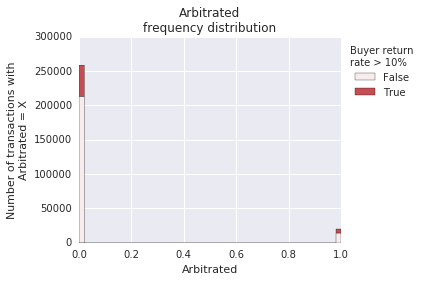

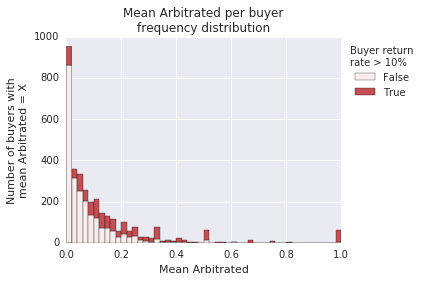

########################################
Feature: Autocheck_score
Timestamp: 2017-02-28T07:12:19GMT


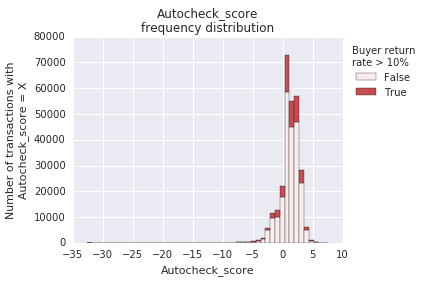

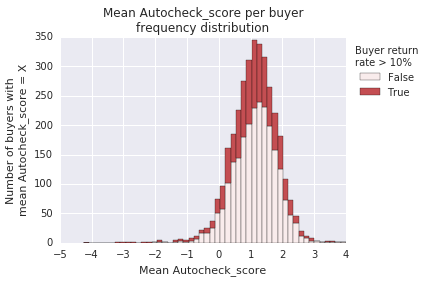

########################################
Feature: BuyerID_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:12:21GMT


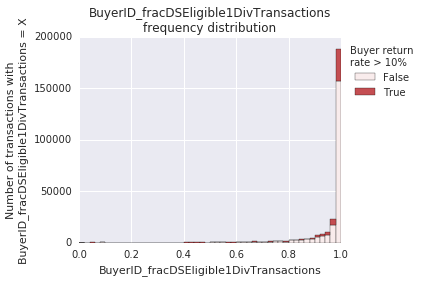

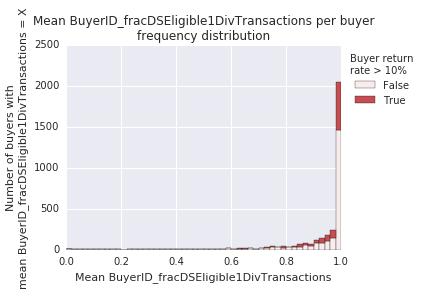

########################################
Feature: BuyerID_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:12:23GMT


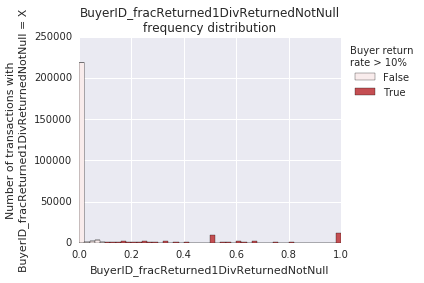

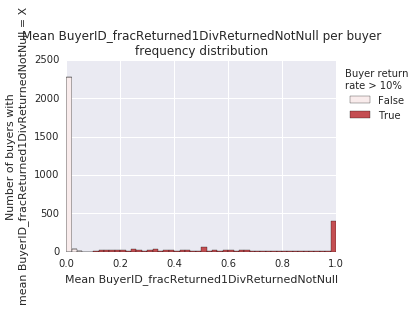

########################################
Feature: BuyerID_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:12:25GMT


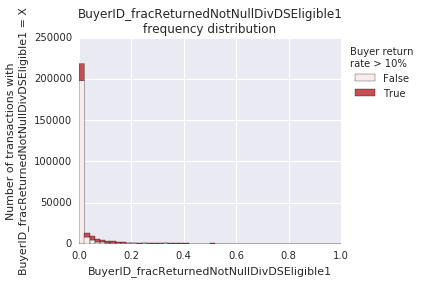

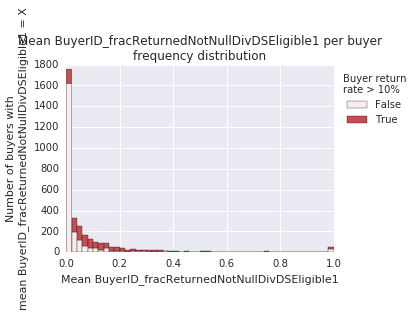

########################################
Feature: BuyerID_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:12:27GMT


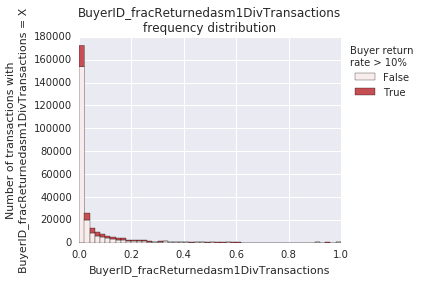

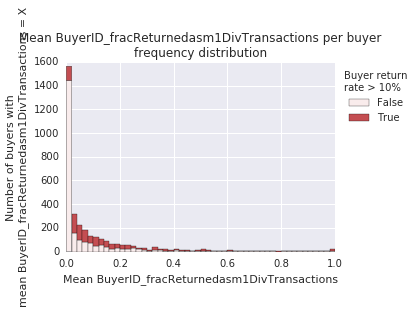

########################################
Feature: BuyerID_numDSEligible1
Timestamp: 2017-02-28T07:12:29GMT


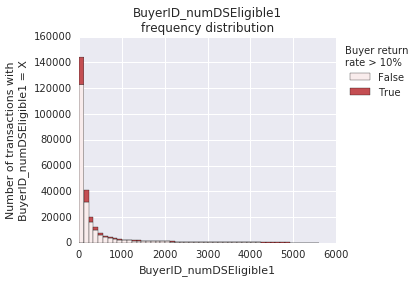

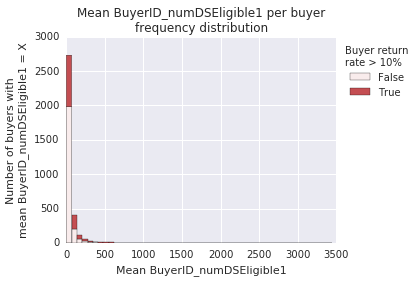

########################################
Feature: BuyerID_numReturned1
Timestamp: 2017-02-28T07:12:31GMT


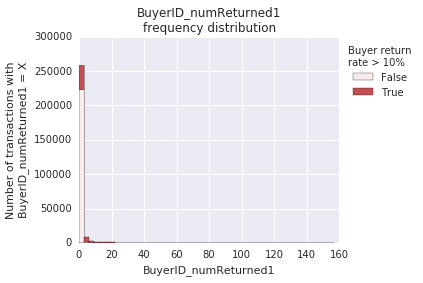

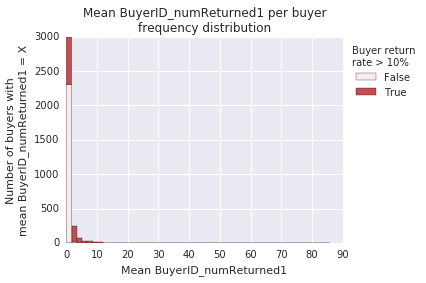

########################################
Feature: BuyerID_numReturnedNotNull
Timestamp: 2017-02-28T07:12:33GMT


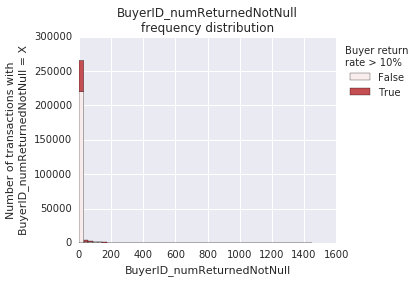

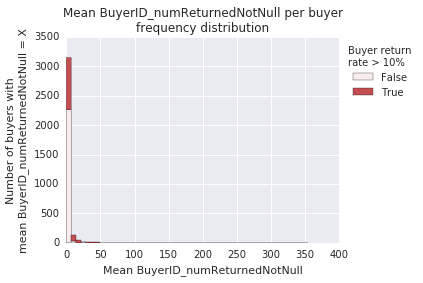

########################################
Feature: BuyerID_numReturnedasm1
Timestamp: 2017-02-28T07:12:35GMT


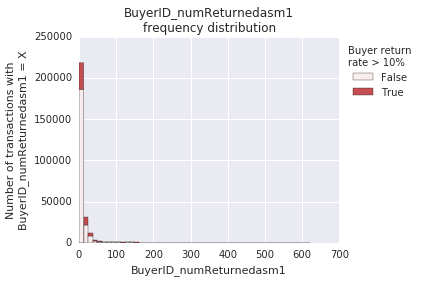

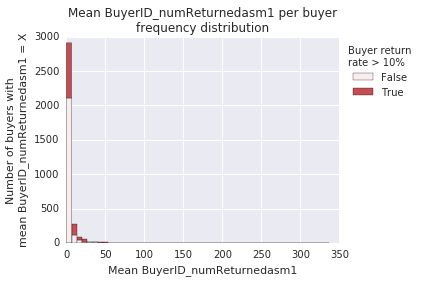

########################################
Feature: BuyerID_numTransactions
Timestamp: 2017-02-28T07:12:37GMT


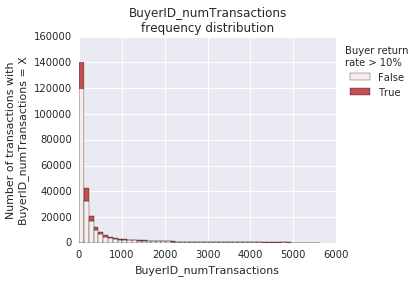

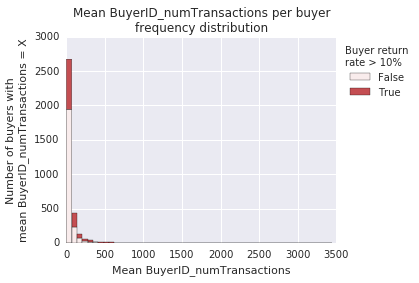

########################################
Feature: CarMake_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:12:39GMT


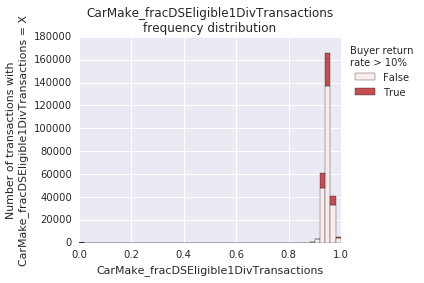

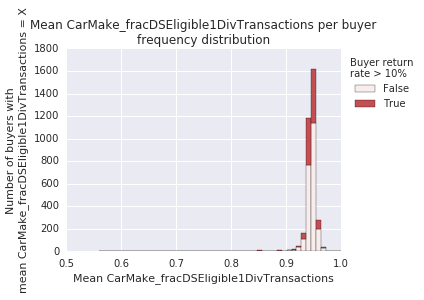

########################################
Feature: CarMake_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:12:41GMT


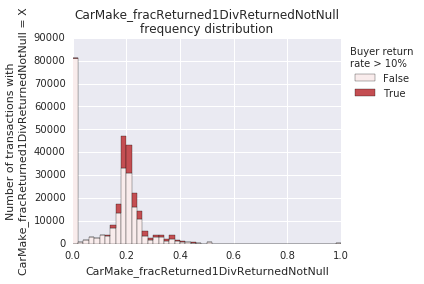

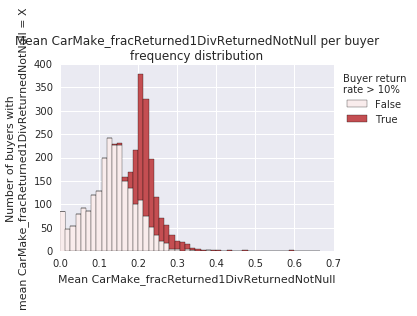

########################################
Feature: CarMake_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:12:43GMT


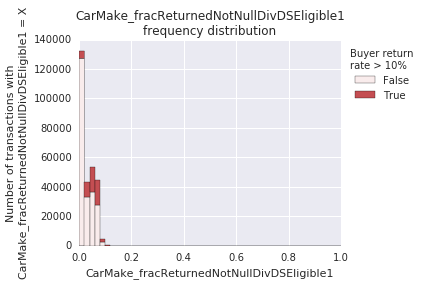

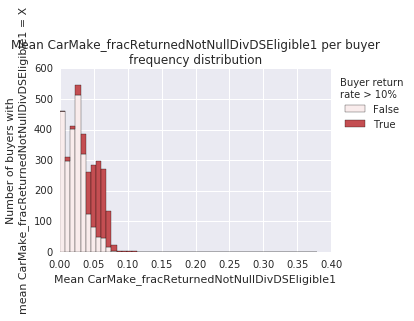

########################################
Feature: CarMake_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:12:45GMT


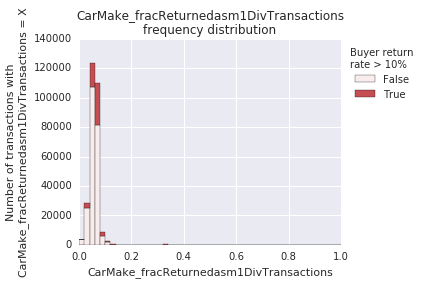

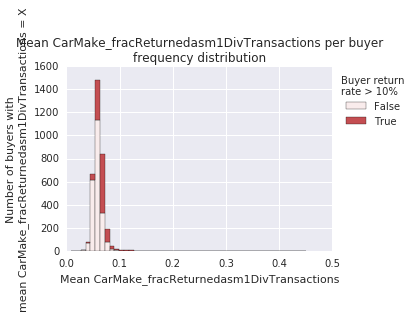

########################################
Feature: CarMake_numDSEligible1
Timestamp: 2017-02-28T07:12:47GMT


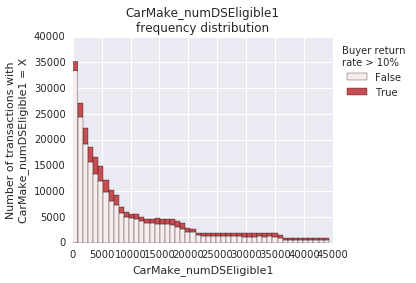

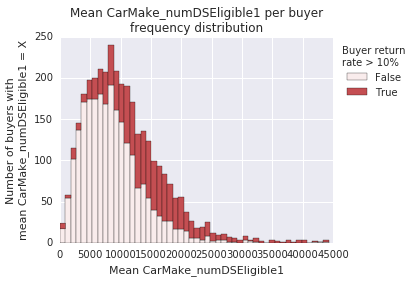

########################################
Feature: CarMake_numReturned1
Timestamp: 2017-02-28T07:12:49GMT


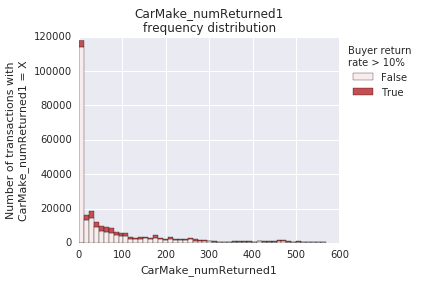

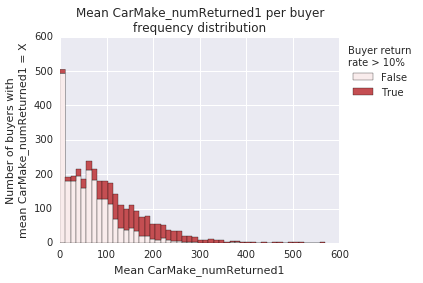

########################################
Feature: CarMake_numReturnedNotNull
Timestamp: 2017-02-28T07:12:51GMT


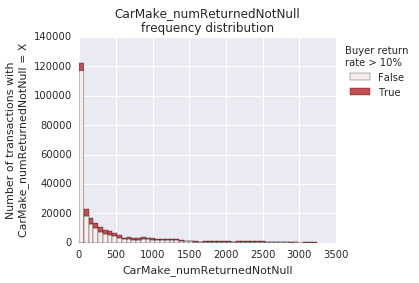

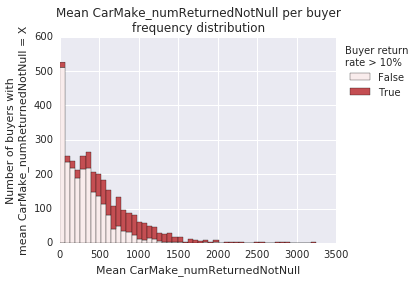

########################################
Feature: CarMake_numReturnedasm1
Timestamp: 2017-02-28T07:12:53GMT


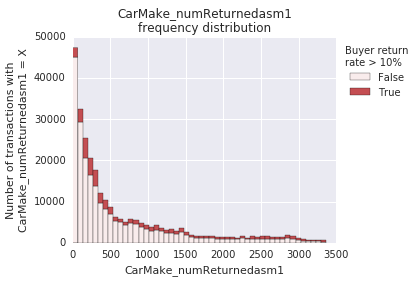

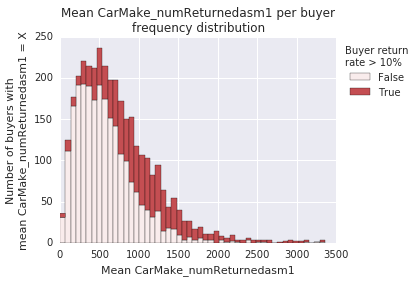

########################################
Feature: CarMake_numTransactions
Timestamp: 2017-02-28T07:12:54GMT


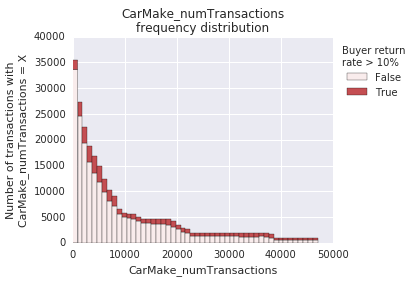

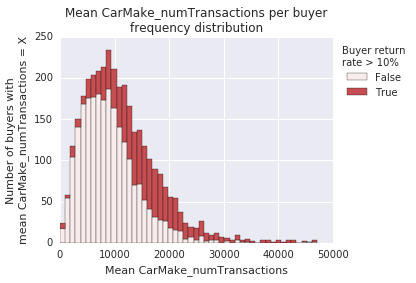

########################################
Feature: CarYear
Timestamp: 2017-02-28T07:12:56GMT


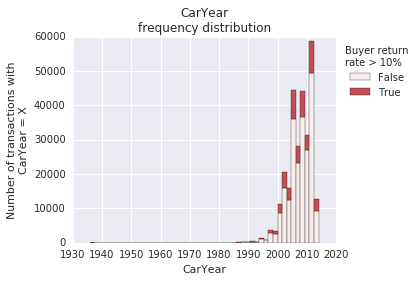

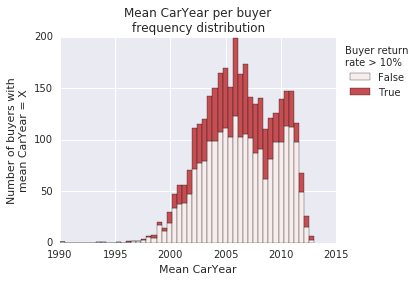

########################################
Feature: ConditionReport
Timestamp: 2017-02-28T07:12:58GMT


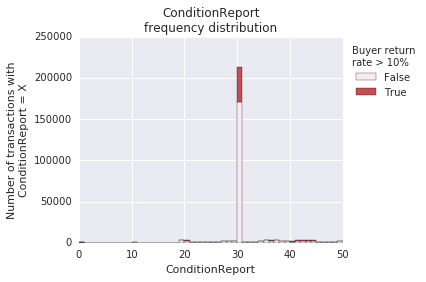

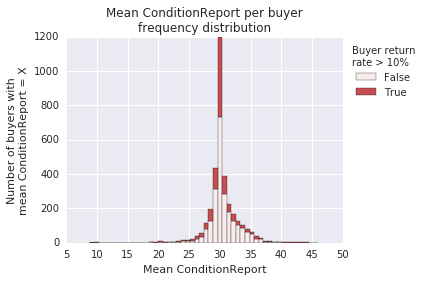

########################################
Feature: DSEligible
Timestamp: 2017-02-28T07:13:00GMT


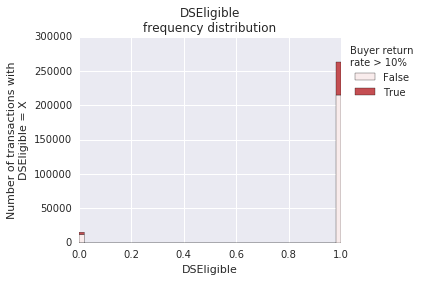

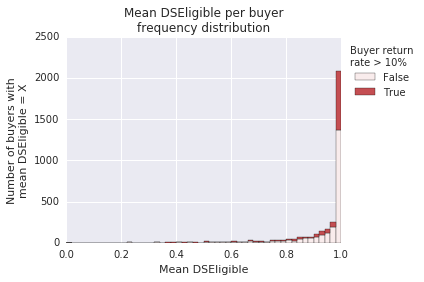

########################################
Feature: InLane
Timestamp: 2017-02-28T07:13:02GMT


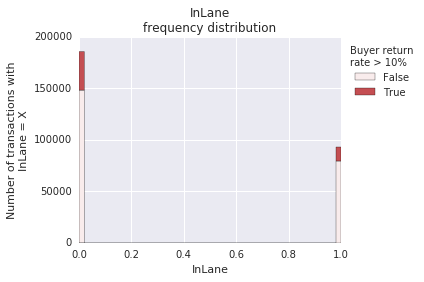

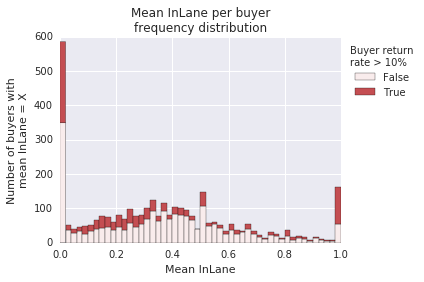

########################################
Feature: JDPowersCat_COMPACTCAR
Timestamp: 2017-02-28T07:13:04GMT


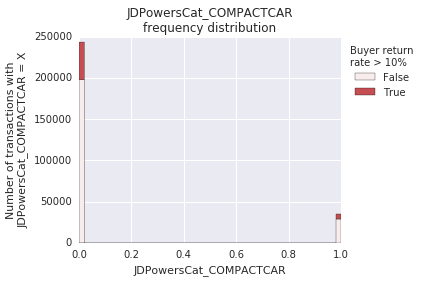

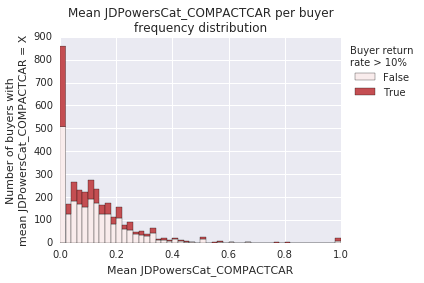

########################################
Feature: JDPowersCat_EXCLUDED
Timestamp: 2017-02-28T07:13:06GMT


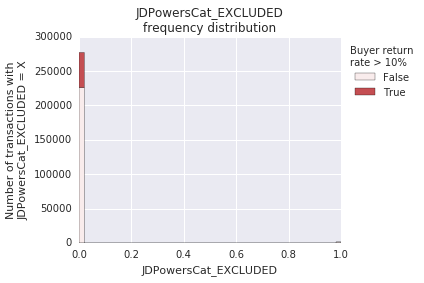

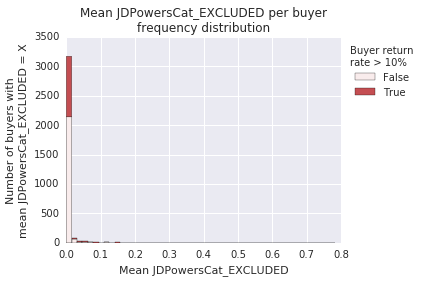

########################################
Feature: JDPowersCat_FULLSIZECAR
Timestamp: 2017-02-28T07:13:08GMT


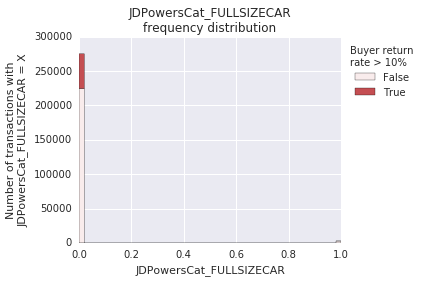

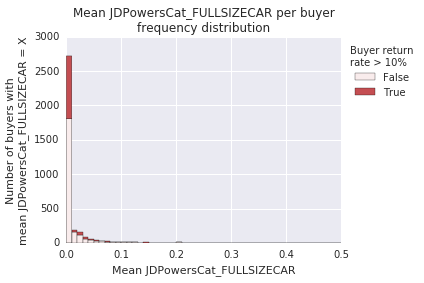

########################################
Feature: JDPowersCat_LUXURYCAR
Timestamp: 2017-02-28T07:13:10GMT


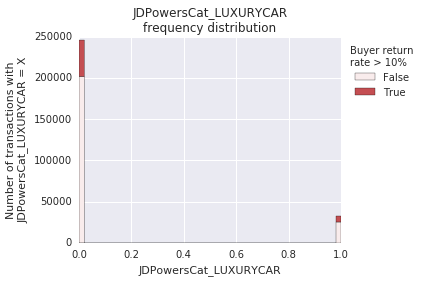

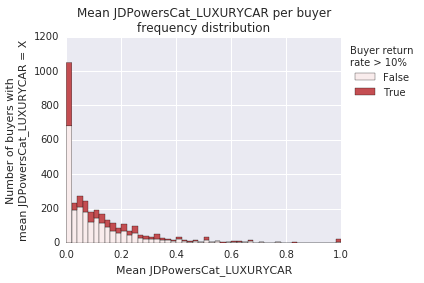

########################################
Feature: JDPowersCat_MIDSIZECAR
Timestamp: 2017-02-28T07:13:12GMT


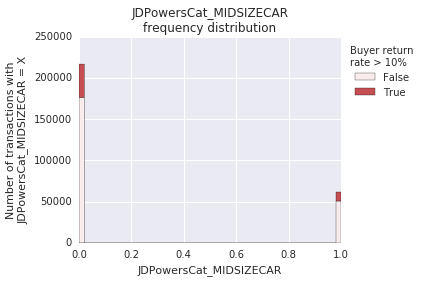

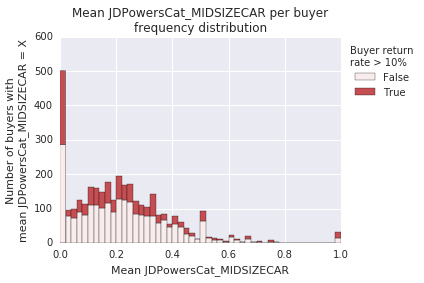

########################################
Feature: JDPowersCat_PICKUP
Timestamp: 2017-02-28T07:13:14GMT


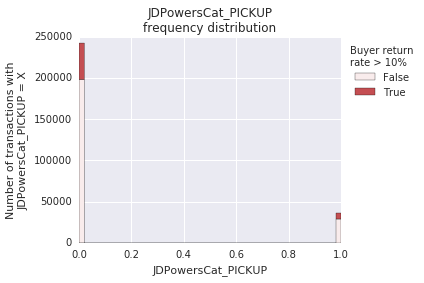

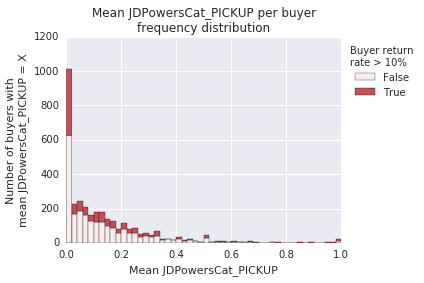

########################################
Feature: JDPowersCat_SPORTSCAR
Timestamp: 2017-02-28T07:13:16GMT


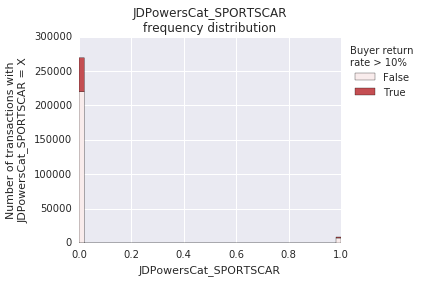

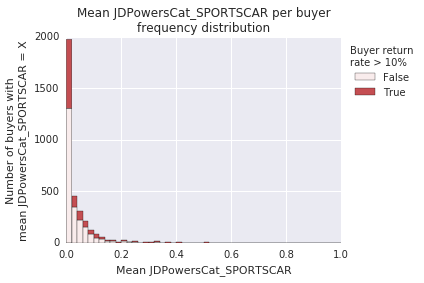

########################################
Feature: JDPowersCat_SUV
Timestamp: 2017-02-28T07:13:18GMT


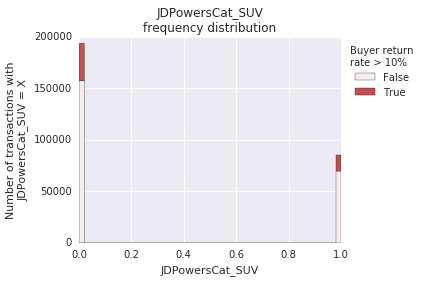

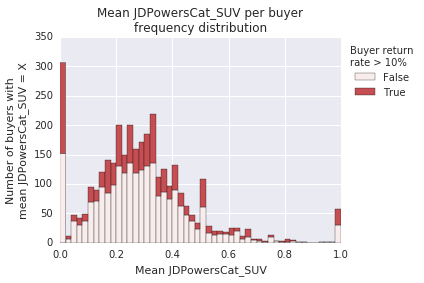

########################################
Feature: JDPowersCat_UNKNOWN
Timestamp: 2017-02-28T07:13:20GMT


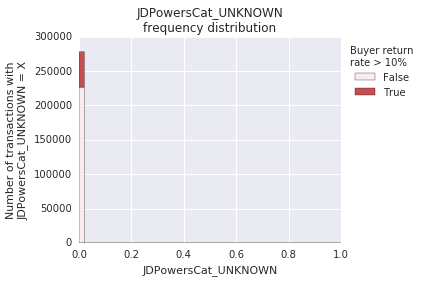

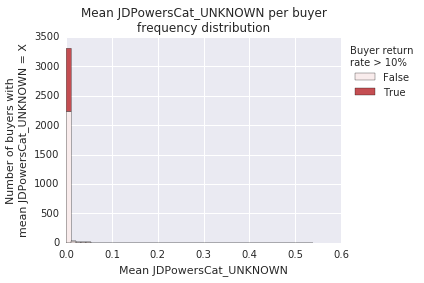

########################################
Feature: JDPowersCat_VAN
Timestamp: 2017-02-28T07:13:22GMT


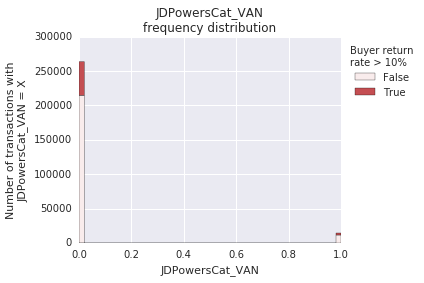

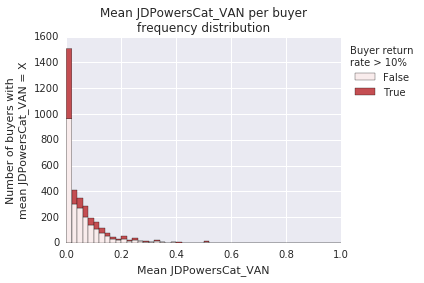

########################################
Feature: JDPowersCat_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:13:24GMT


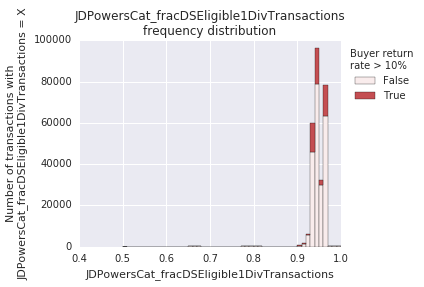

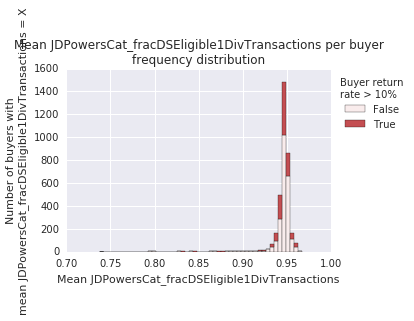

########################################
Feature: JDPowersCat_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:13:26GMT


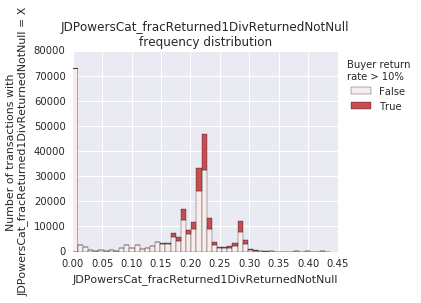

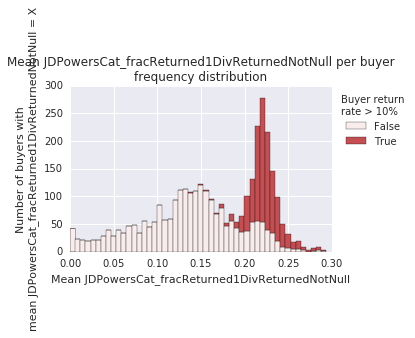

########################################
Feature: JDPowersCat_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:13:28GMT


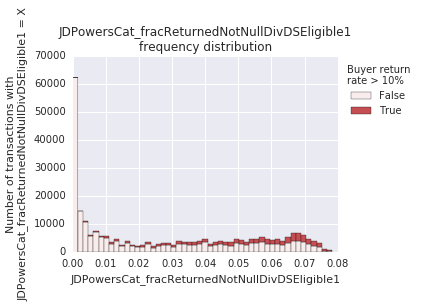

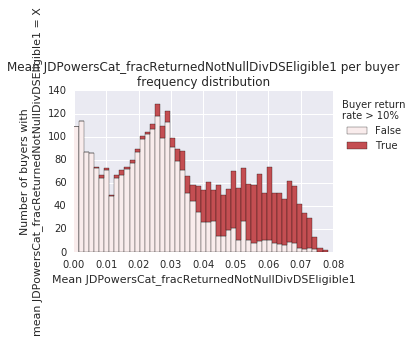

########################################
Feature: JDPowersCat_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:13:30GMT


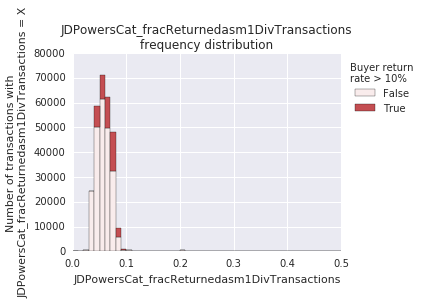

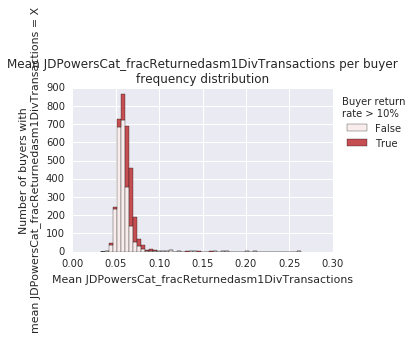

########################################
Feature: JDPowersCat_numDSEligible1
Timestamp: 2017-02-28T07:13:32GMT


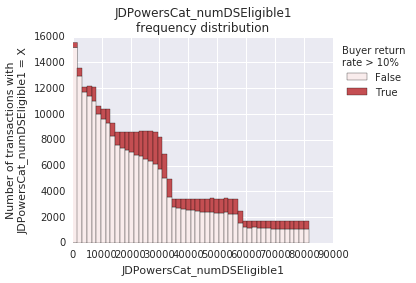

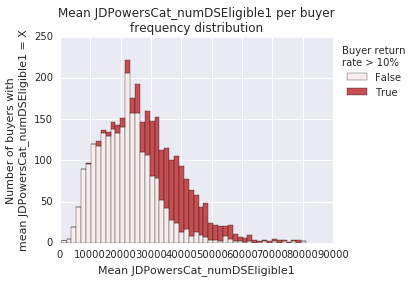

########################################
Feature: JDPowersCat_numReturned1
Timestamp: 2017-02-28T07:13:33GMT


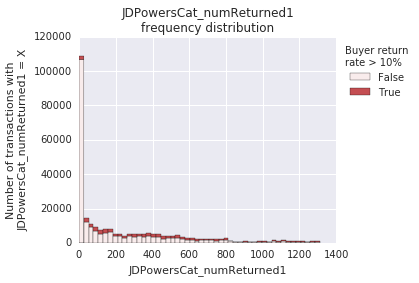

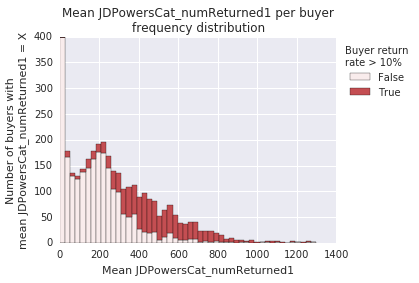

########################################
Feature: JDPowersCat_numReturnedNotNull
Timestamp: 2017-02-28T07:13:35GMT


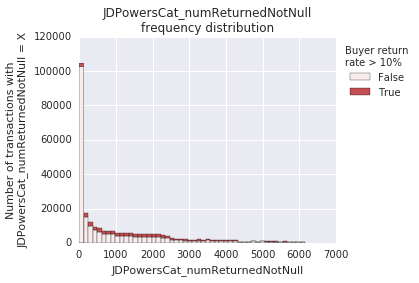

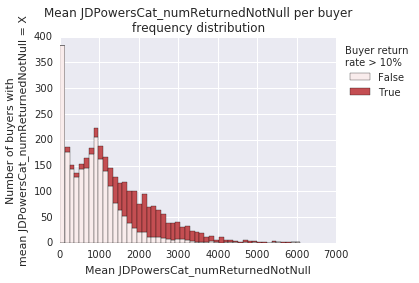

########################################
Feature: JDPowersCat_numReturnedasm1
Timestamp: 2017-02-28T07:13:37GMT


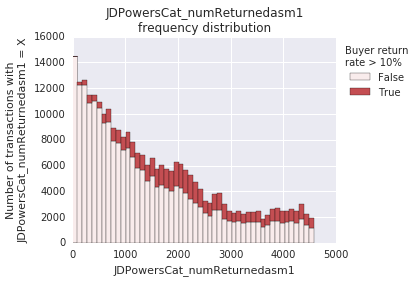

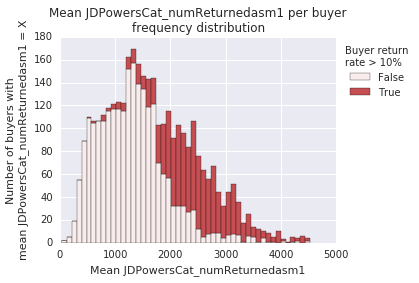

########################################
Feature: JDPowersCat_numTransactions
Timestamp: 2017-02-28T07:13:39GMT


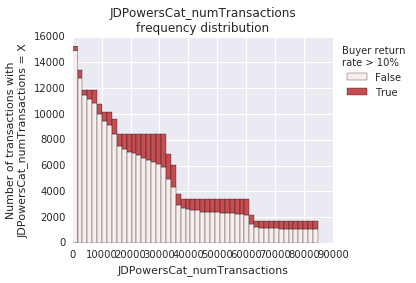

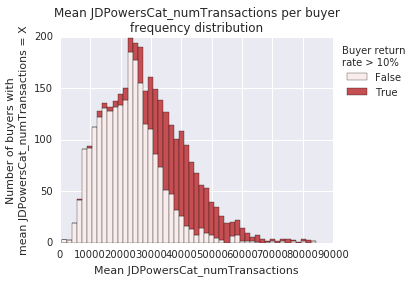

########################################
Feature: LIGHTG
Timestamp: 2017-02-28T07:13:41GMT


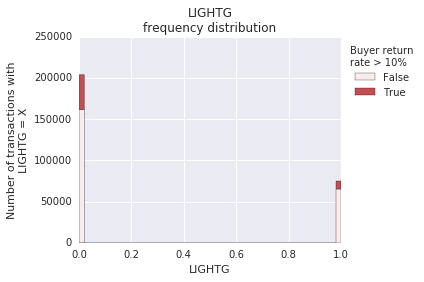

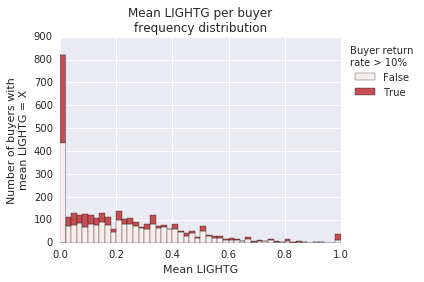

########################################
Feature: LIGHTR
Timestamp: 2017-02-28T07:13:43GMT


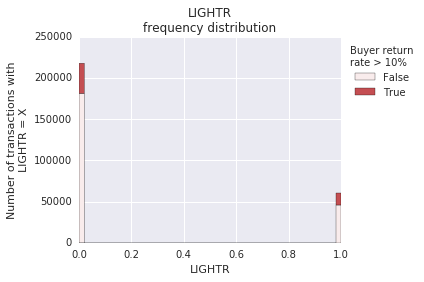

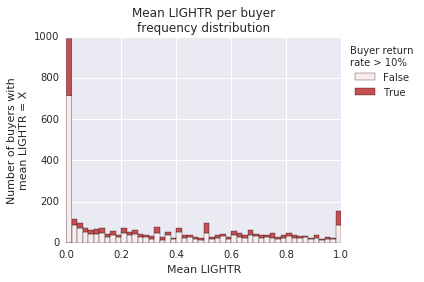

########################################
Feature: LIGHTY
Timestamp: 2017-02-28T07:13:45GMT


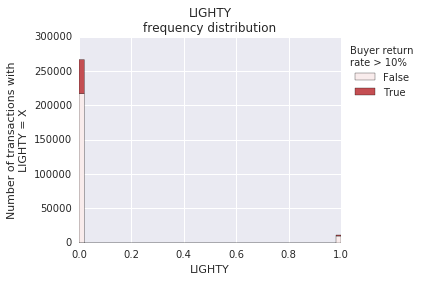

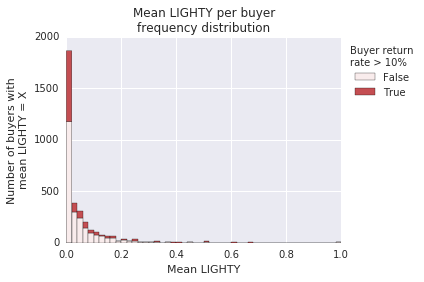

########################################
Feature: LIGHT_N0G1Y2R3
Timestamp: 2017-02-28T07:13:46GMT


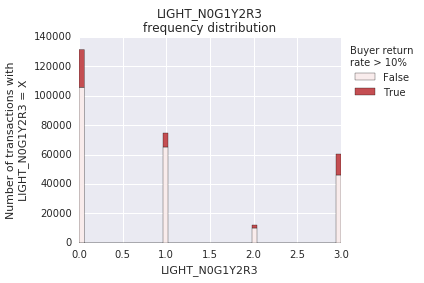

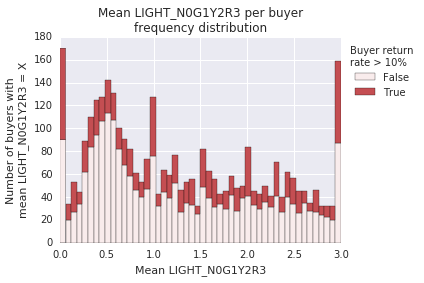

########################################
Feature: MMR
Timestamp: 2017-02-28T07:13:48GMT


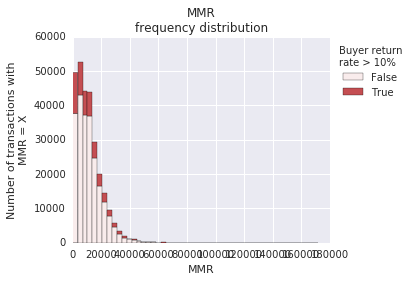

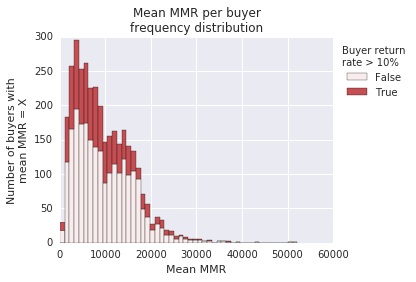

########################################
Feature: Mileage
Timestamp: 2017-02-28T07:13:50GMT


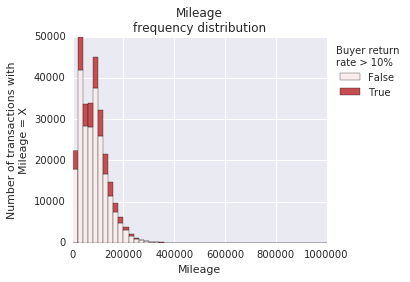

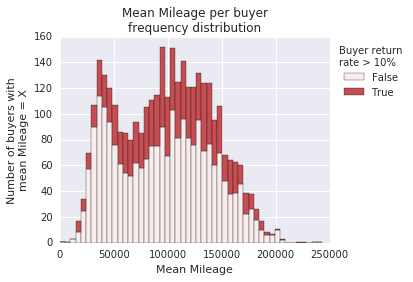

########################################
Feature: OVE
Timestamp: 2017-02-28T07:13:52GMT


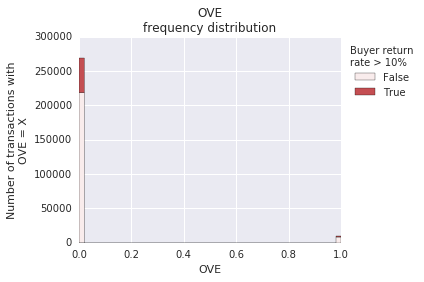

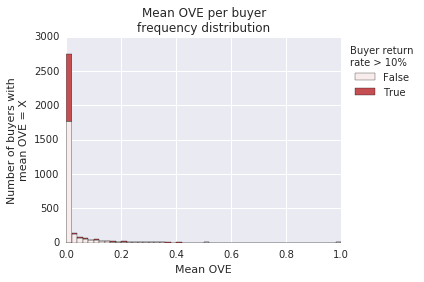

########################################
Feature: PSI
Timestamp: 2017-02-28T07:13:54GMT


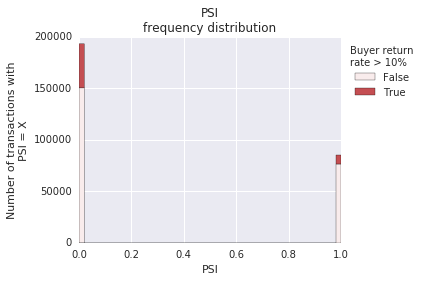

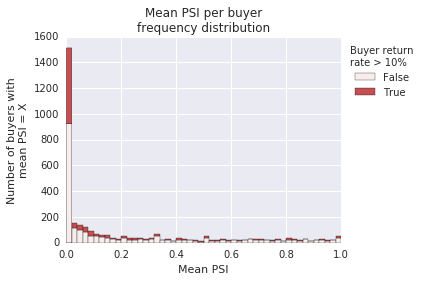

########################################
Feature: PSIEligible
Timestamp: 2017-02-28T07:13:55GMT


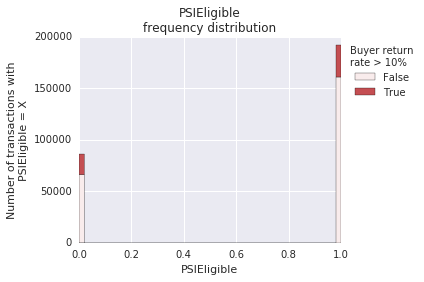

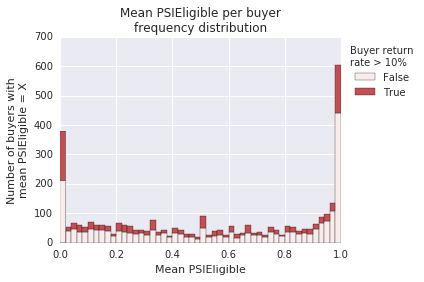

########################################
Feature: Returned
Timestamp: 2017-02-28T07:13:57GMT


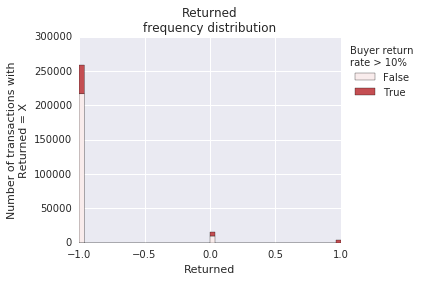

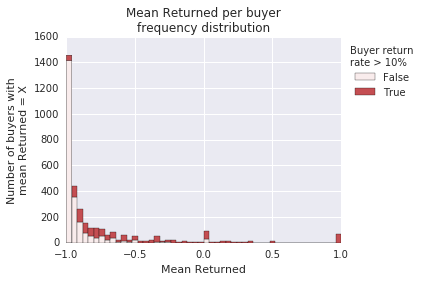

########################################
Feature: Returned_asm
Timestamp: 2017-02-28T07:13:59GMT


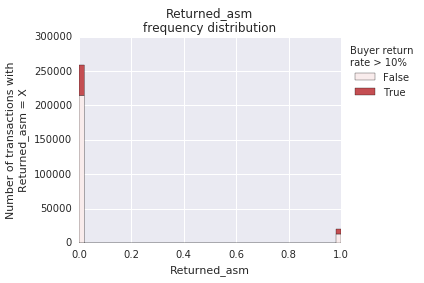

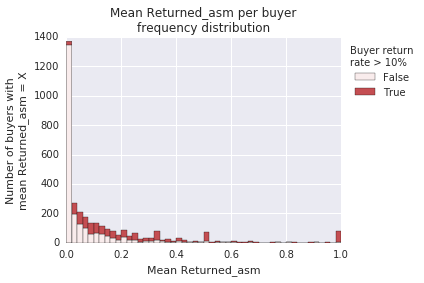

########################################
Feature: SaleDate_day
Timestamp: 2017-02-28T07:14:01GMT


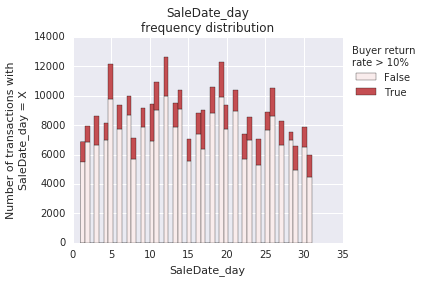

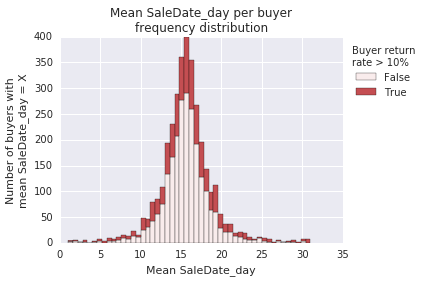

########################################
Feature: SaleDate_decyear
Timestamp: 2017-02-28T07:14:03GMT


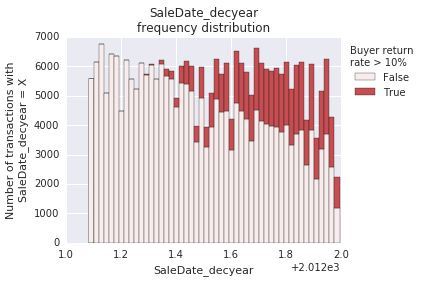

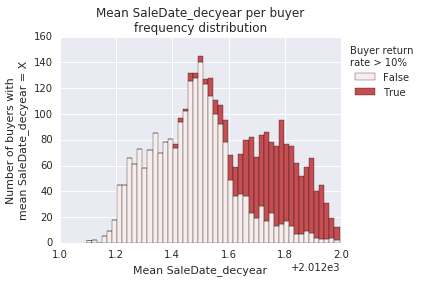

########################################
Feature: SaleDate_dow
Timestamp: 2017-02-28T07:14:04GMT


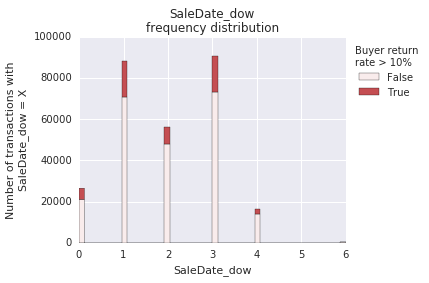

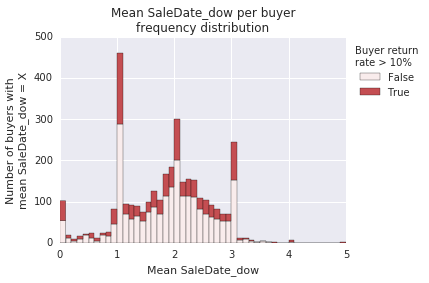

########################################
Feature: SaleDate_doy
Timestamp: 2017-02-28T07:14:06GMT


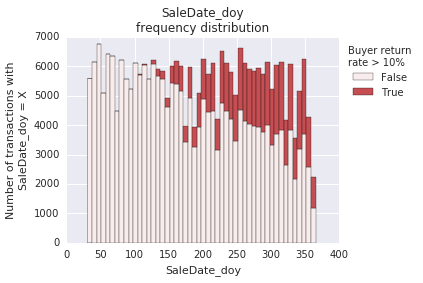

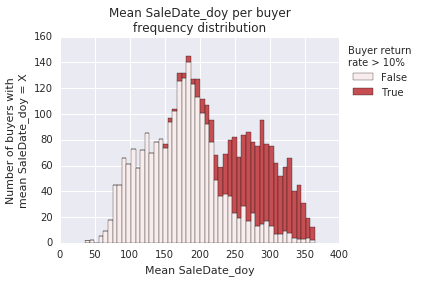

########################################
Feature: SalePrice
Timestamp: 2017-02-28T07:14:08GMT


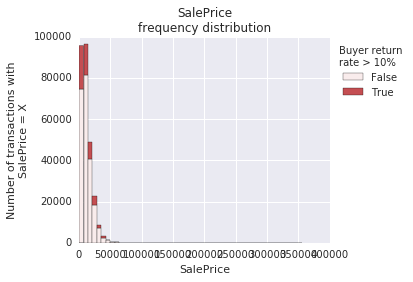

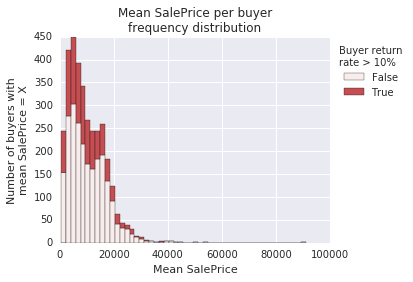

########################################
Feature: Salvage
Timestamp: 2017-02-28T07:14:10GMT


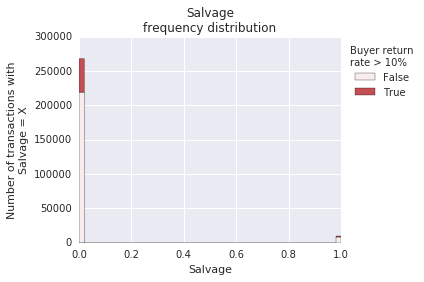

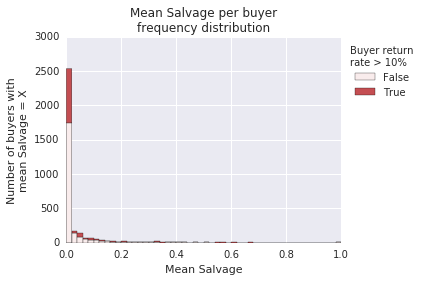

########################################
Feature: SellerID_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:14:12GMT


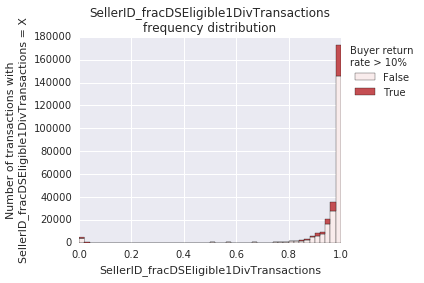

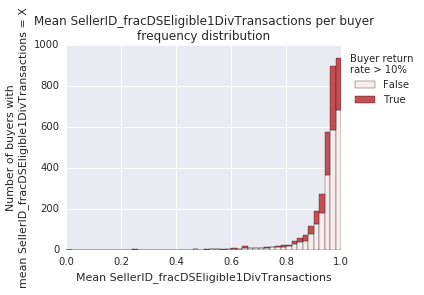

########################################
Feature: SellerID_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:14:14GMT


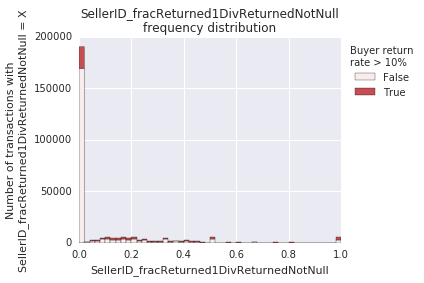

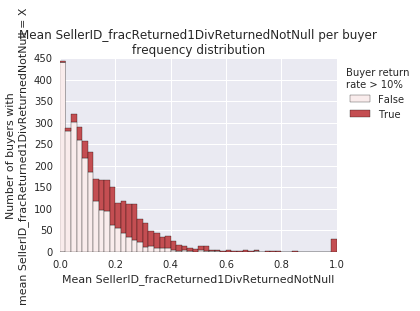

########################################
Feature: SellerID_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:14:15GMT


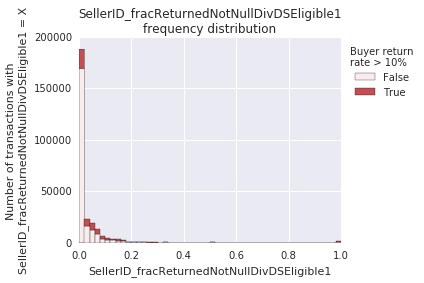

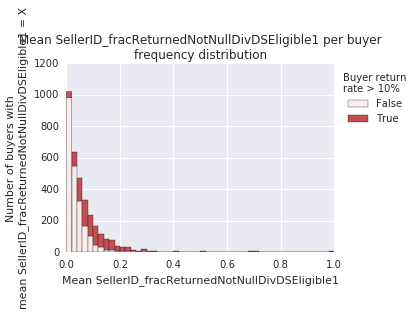

########################################
Feature: SellerID_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:14:17GMT


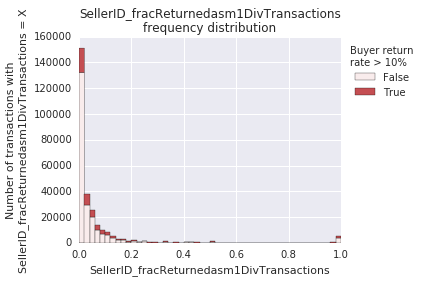

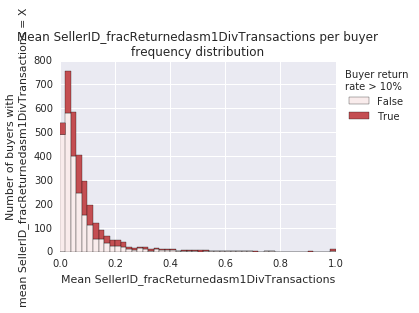

########################################
Feature: SellerID_numDSEligible1
Timestamp: 2017-02-28T07:14:19GMT


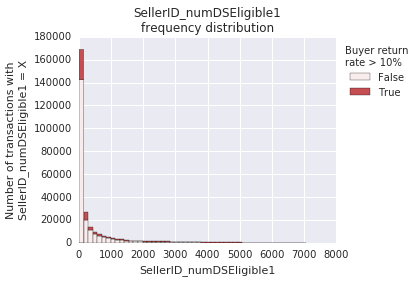

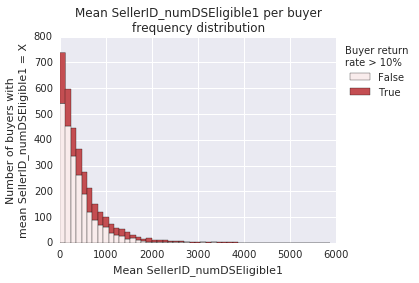

########################################
Feature: SellerID_numReturned1
Timestamp: 2017-02-28T07:14:21GMT


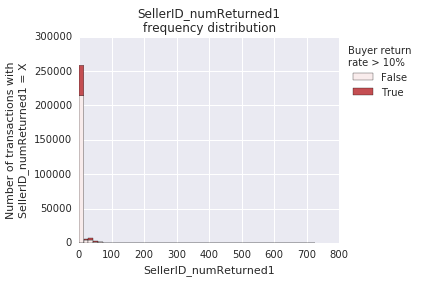

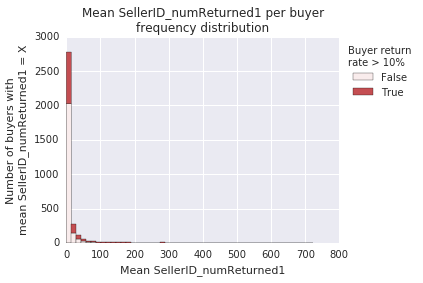

########################################
Feature: SellerID_numReturnedNotNull
Timestamp: 2017-02-28T07:14:23GMT


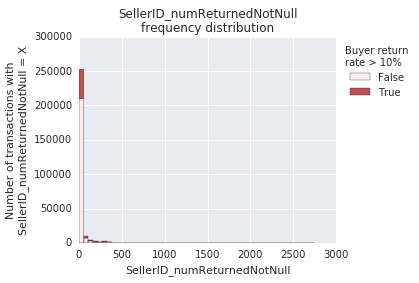

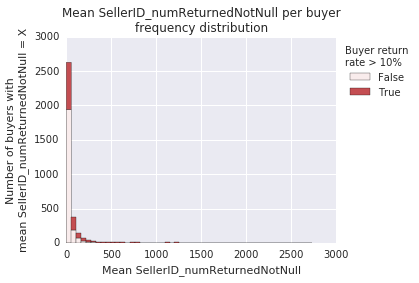

########################################
Feature: SellerID_numReturnedasm1
Timestamp: 2017-02-28T07:14:25GMT


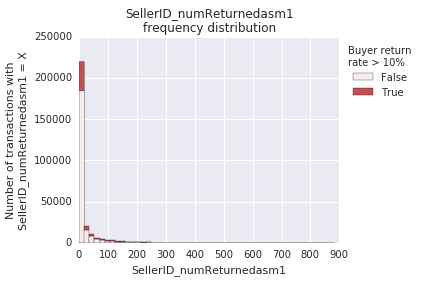

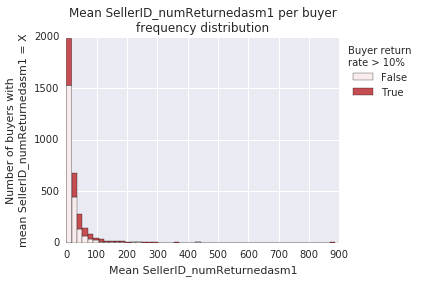

########################################
Feature: SellerID_numTransactions
Timestamp: 2017-02-28T07:14:26GMT


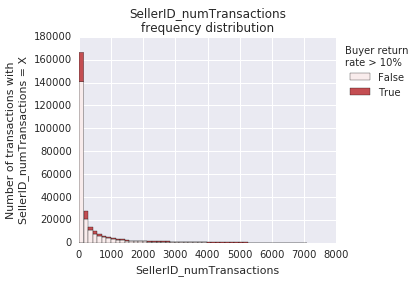

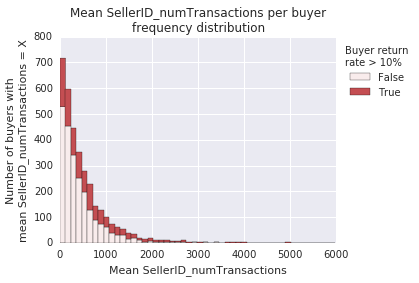

########################################
Feature: SellingLocation_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:14:28GMT


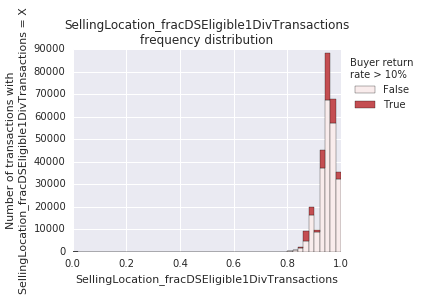

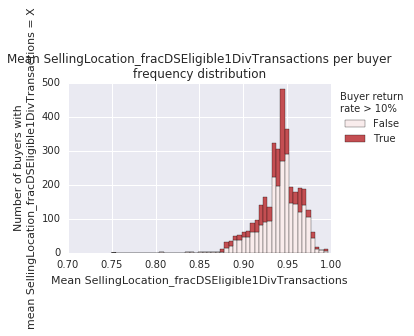

########################################
Feature: SellingLocation_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:14:30GMT


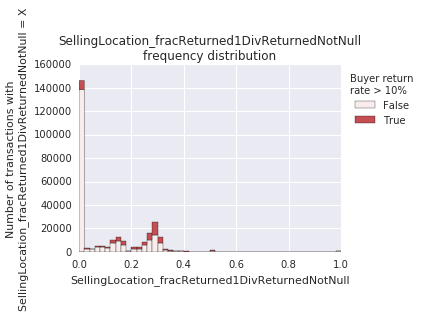

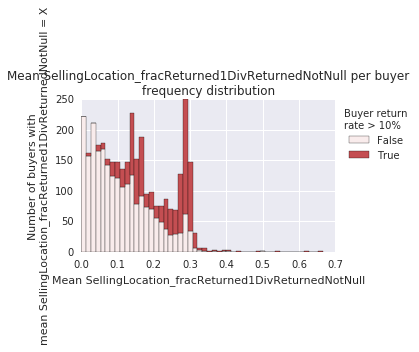

########################################
Feature: SellingLocation_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:14:32GMT


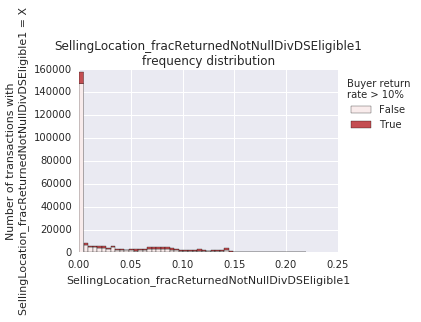

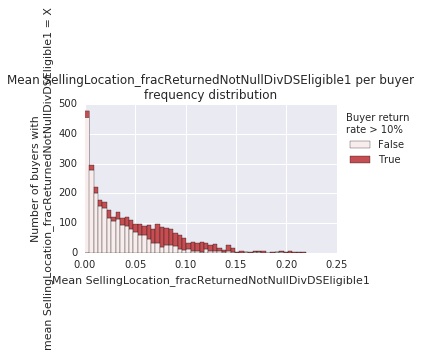

########################################
Feature: SellingLocation_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:14:34GMT


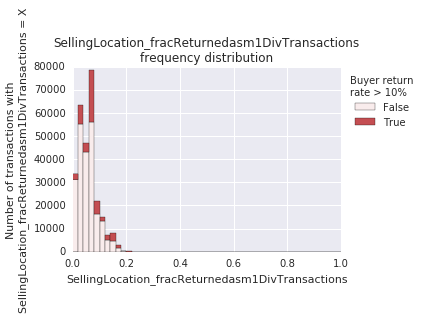

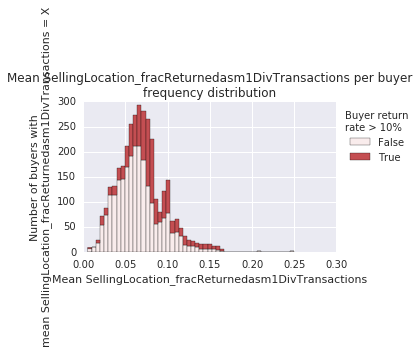

########################################
Feature: SellingLocation_lat
Timestamp: 2017-02-28T07:14:36GMT


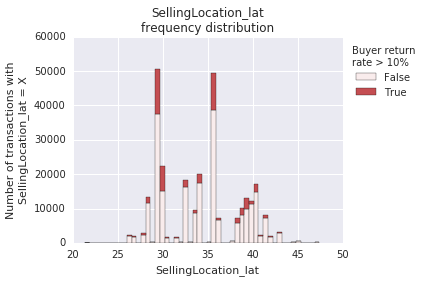

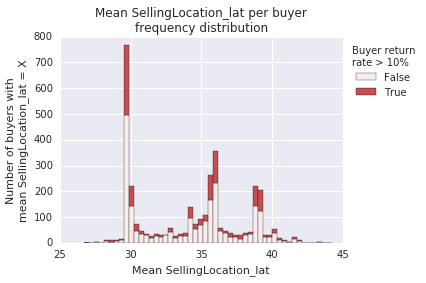

########################################
Feature: SellingLocation_lon
Timestamp: 2017-02-28T07:14:38GMT


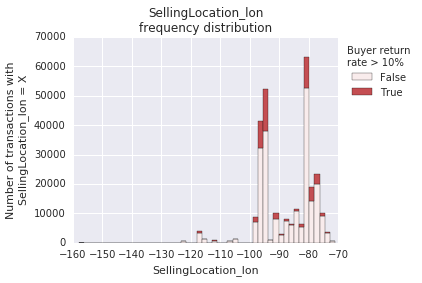

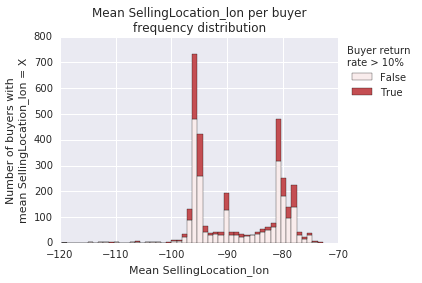

########################################
Feature: SellingLocation_numDSEligible1
Timestamp: 2017-02-28T07:14:40GMT


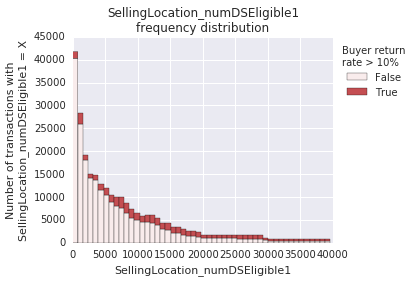

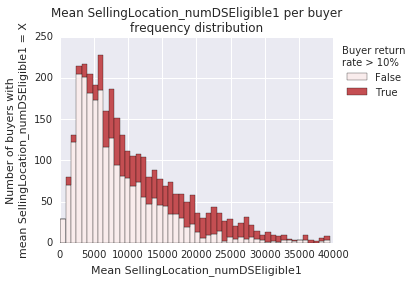

########################################
Feature: SellingLocation_numReturned1
Timestamp: 2017-02-28T07:14:42GMT


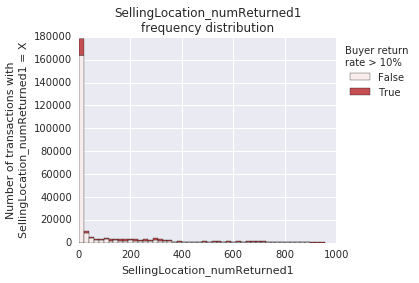

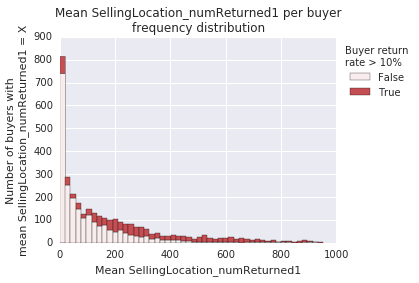

########################################
Feature: SellingLocation_numReturnedNotNull
Timestamp: 2017-02-28T07:14:43GMT


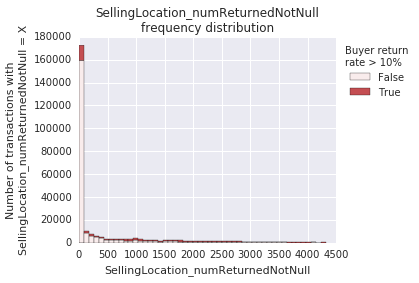

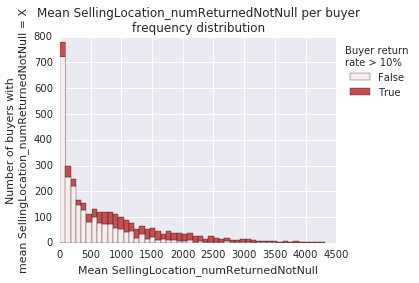

########################################
Feature: SellingLocation_numReturnedasm1
Timestamp: 2017-02-28T07:14:45GMT


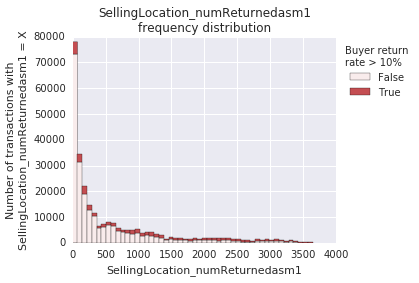

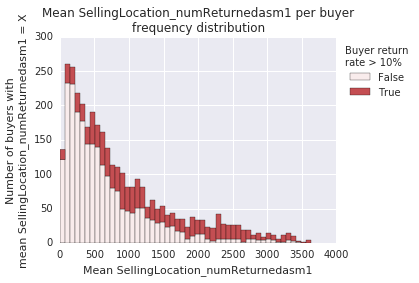

########################################
Feature: SellingLocation_numTransactions
Timestamp: 2017-02-28T07:14:47GMT


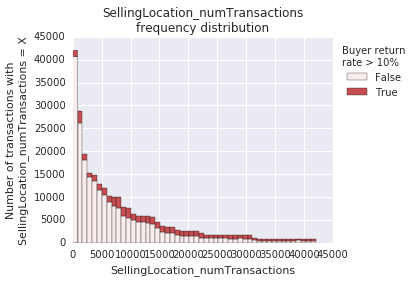

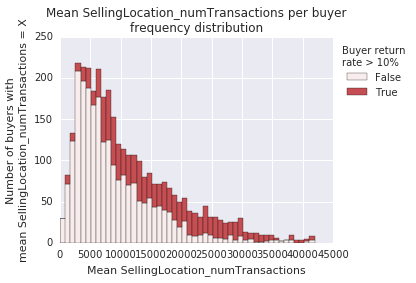

########################################
Feature: Simulcast
Timestamp: 2017-02-28T07:14:49GMT


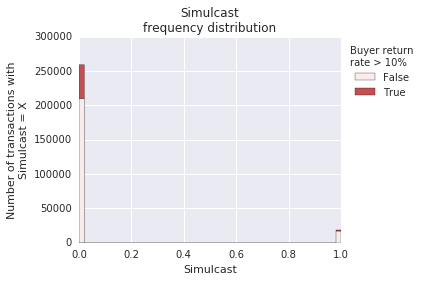

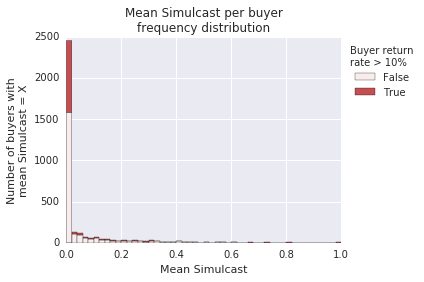

########################################
Feature: VIN_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:14:51GMT


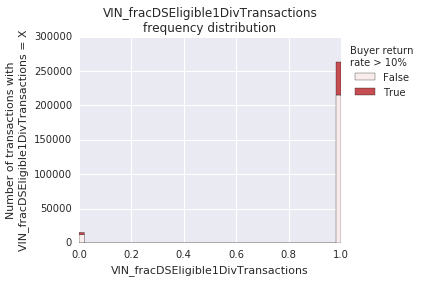

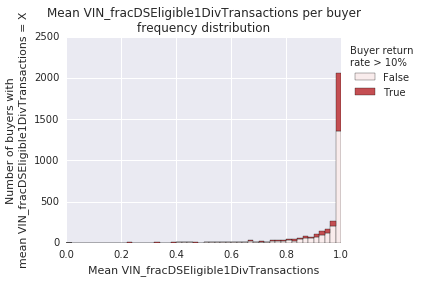

########################################
Feature: VIN_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:14:53GMT


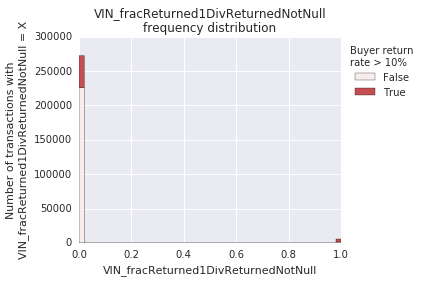

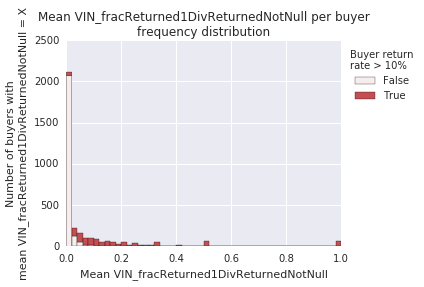

########################################
Feature: VIN_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:14:55GMT


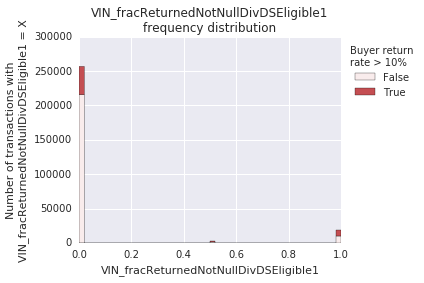

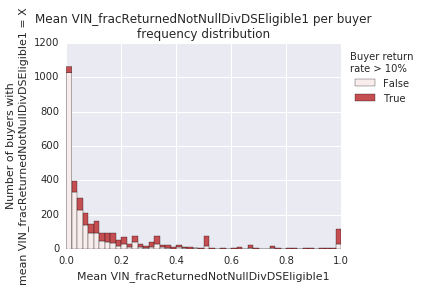

########################################
Feature: VIN_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:14:56GMT


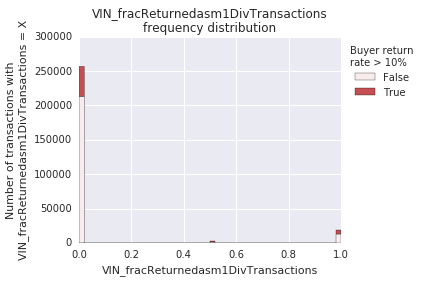

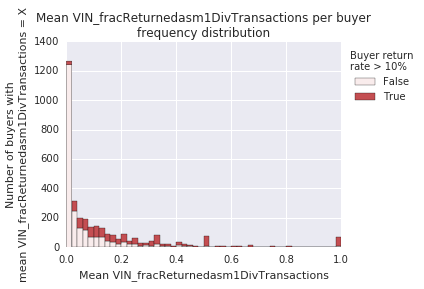

########################################
Feature: VIN_numDSEligible1
Timestamp: 2017-02-28T07:14:58GMT


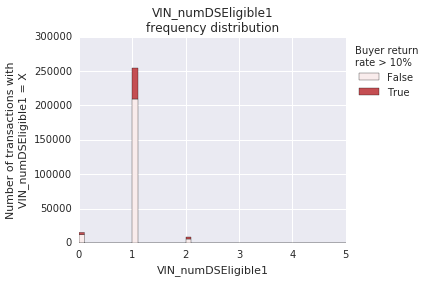

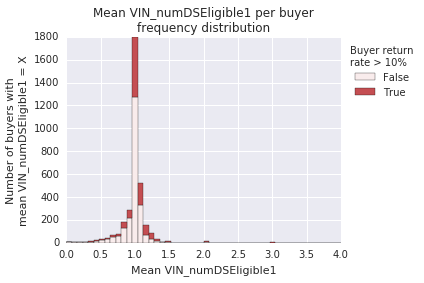

########################################
Feature: VIN_numReturned1
Timestamp: 2017-02-28T07:15:00GMT


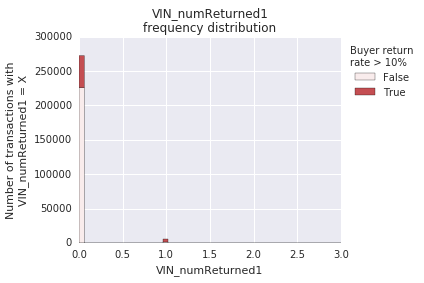

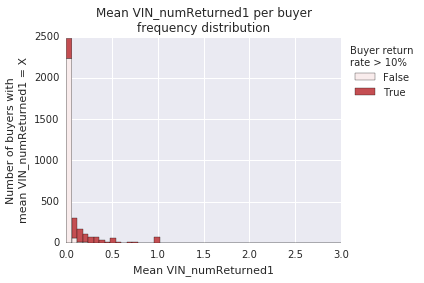

########################################
Feature: VIN_numReturnedNotNull
Timestamp: 2017-02-28T07:15:02GMT


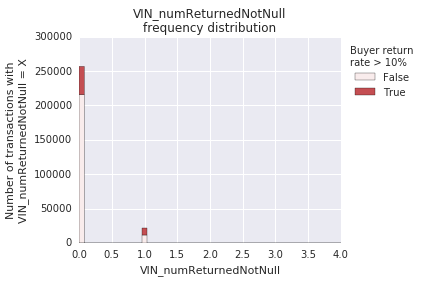

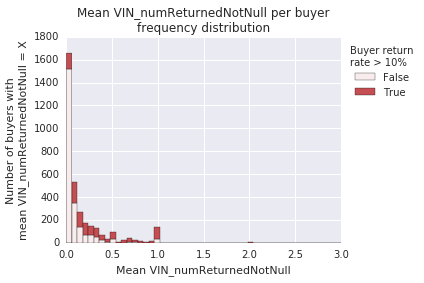

########################################
Feature: VIN_numReturnedasm1
Timestamp: 2017-02-28T07:15:04GMT


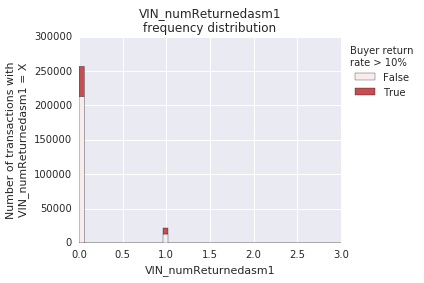

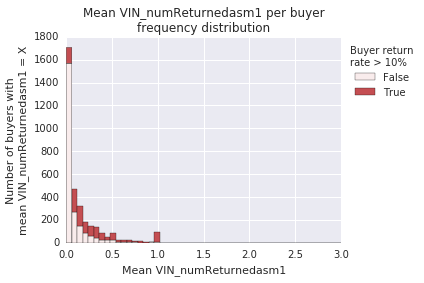

########################################
Feature: VIN_numTransactions
Timestamp: 2017-02-28T07:15:06GMT


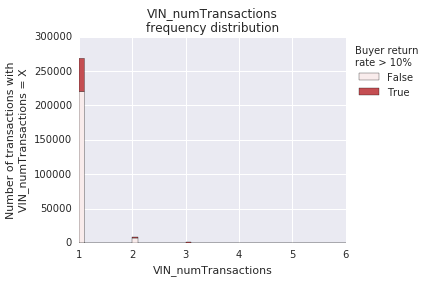

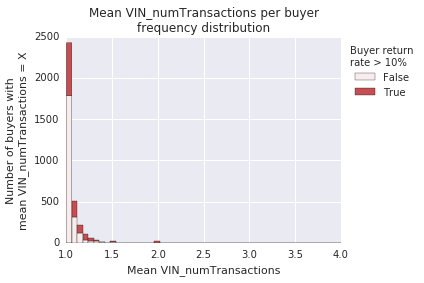

################################################################################
Plot traces (timeseries) for fractional quantities vs fraction of completed transactions.
########################################
Category column:    BuyerID
Transaction column: BuyerID_numTransactions
Fraction column:    BuyerID_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:15:07GMT


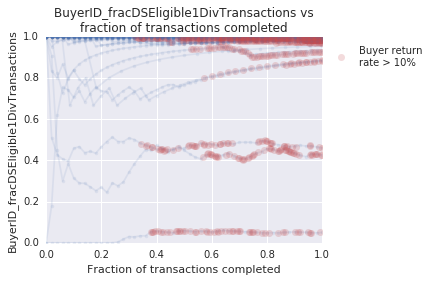

########################################
Category column:    BuyerID
Transaction column: BuyerID_numTransactions
Fraction column:    BuyerID_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:15:31GMT


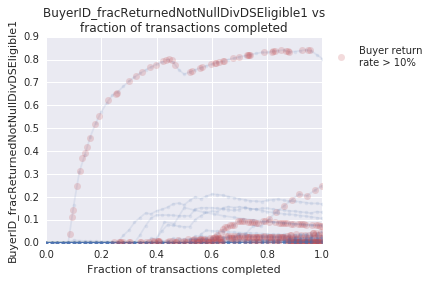

########################################
Category column:    BuyerID
Transaction column: BuyerID_numTransactions
Fraction column:    BuyerID_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:15:55GMT


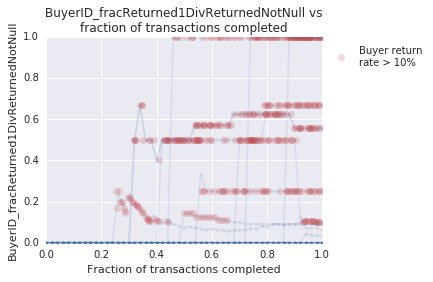

########################################
Category column:    BuyerID
Transaction column: BuyerID_numTransactions
Fraction column:    BuyerID_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:16:19GMT


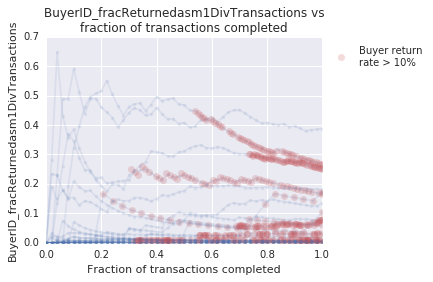

########################################
Category column:    SellerID
Transaction column: SellerID_numTransactions
Fraction column:    SellerID_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:16:43GMT


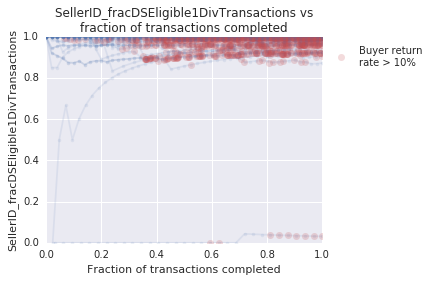

########################################
Category column:    SellerID
Transaction column: SellerID_numTransactions
Fraction column:    SellerID_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:17:06GMT


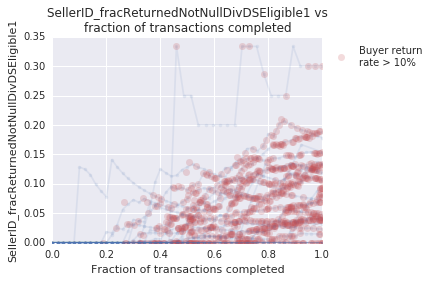

########################################
Category column:    SellerID
Transaction column: SellerID_numTransactions
Fraction column:    SellerID_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:17:28GMT


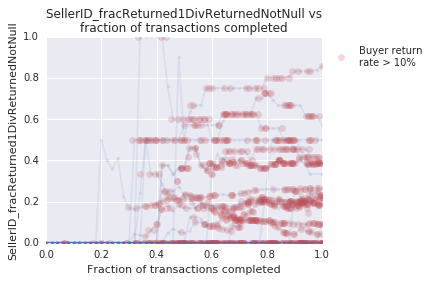

########################################
Category column:    SellerID
Transaction column: SellerID_numTransactions
Fraction column:    SellerID_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:17:51GMT


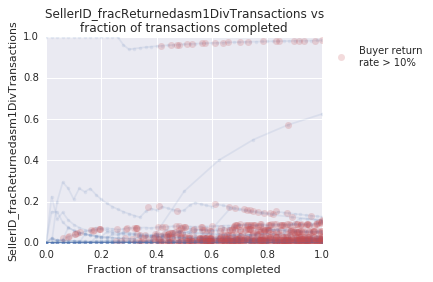

########################################
Category column:    VIN
Transaction column: VIN_numTransactions
Fraction column:    VIN_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:18:13GMT


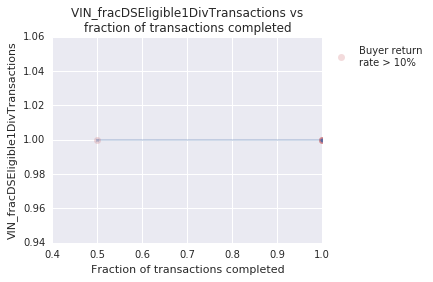

########################################
Category column:    VIN
Transaction column: VIN_numTransactions
Fraction column:    VIN_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:18:36GMT


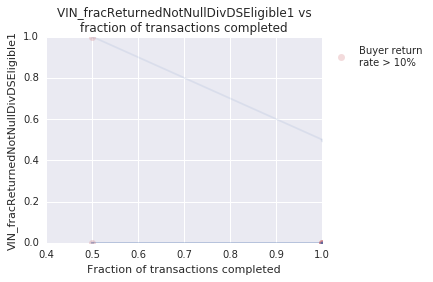

########################################
Category column:    VIN
Transaction column: VIN_numTransactions
Fraction column:    VIN_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:19:00GMT


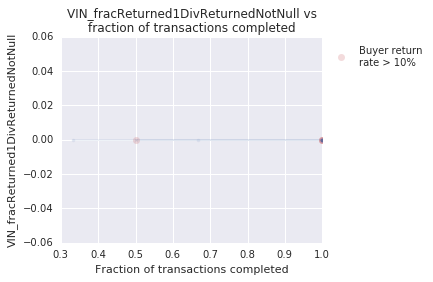

########################################
Category column:    VIN
Transaction column: VIN_numTransactions
Fraction column:    VIN_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:19:23GMT


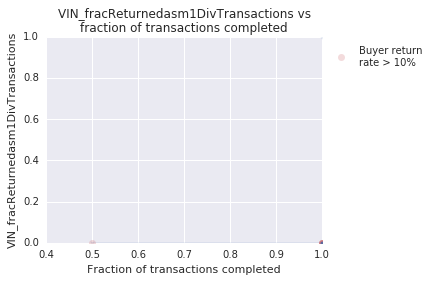

########################################
Category column:    SellingLocation
Transaction column: SellingLocation_numTransactions
Fraction column:    SellingLocation_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:19:46GMT


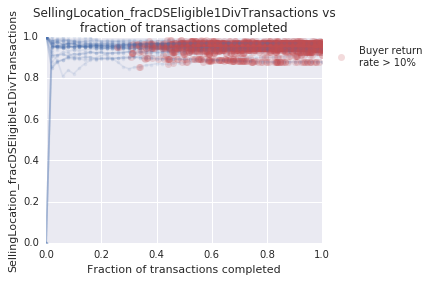

########################################
Category column:    SellingLocation
Transaction column: SellingLocation_numTransactions
Fraction column:    SellingLocation_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:20:08GMT


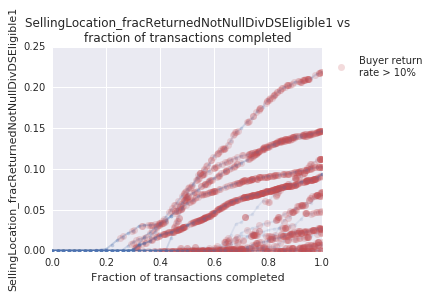

########################################
Category column:    SellingLocation
Transaction column: SellingLocation_numTransactions
Fraction column:    SellingLocation_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:20:29GMT


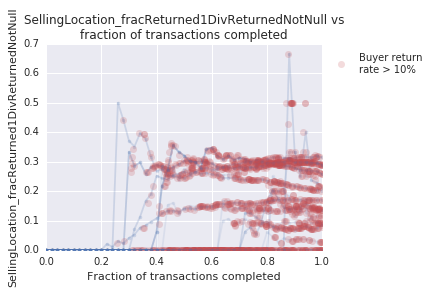

########################################
Category column:    SellingLocation
Transaction column: SellingLocation_numTransactions
Fraction column:    SellingLocation_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:20:51GMT


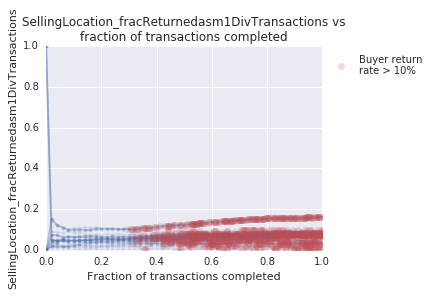

########################################
Category column:    CarMake
Transaction column: CarMake_numTransactions
Fraction column:    CarMake_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:21:12GMT


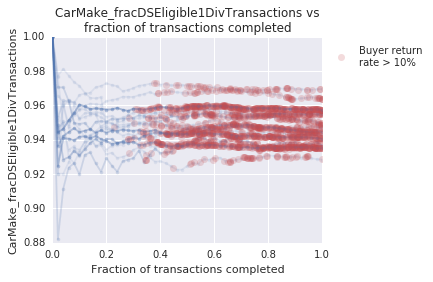

########################################
Category column:    CarMake
Transaction column: CarMake_numTransactions
Fraction column:    CarMake_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:21:34GMT


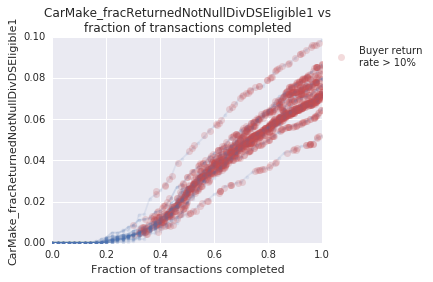

########################################
Category column:    CarMake
Transaction column: CarMake_numTransactions
Fraction column:    CarMake_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:21:55GMT


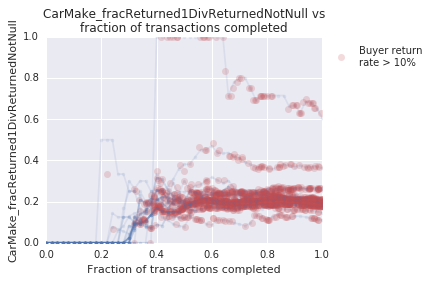

########################################
Category column:    CarMake
Transaction column: CarMake_numTransactions
Fraction column:    CarMake_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:22:16GMT


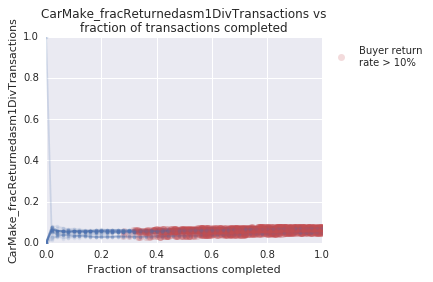

########################################
Category column:    JDPowersCat
Transaction column: JDPowersCat_numTransactions
Fraction column:    JDPowersCat_fracDSEligible1DivTransactions
Timestamp: 2017-02-28T07:22:38GMT


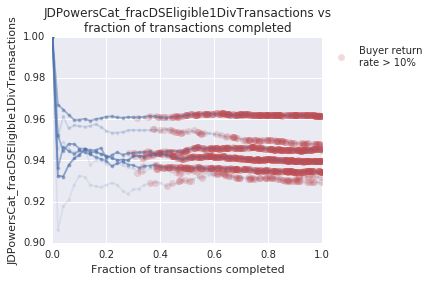

########################################
Category column:    JDPowersCat
Transaction column: JDPowersCat_numTransactions
Fraction column:    JDPowersCat_fracReturnedNotNullDivDSEligible1
Timestamp: 2017-02-28T07:23:00GMT


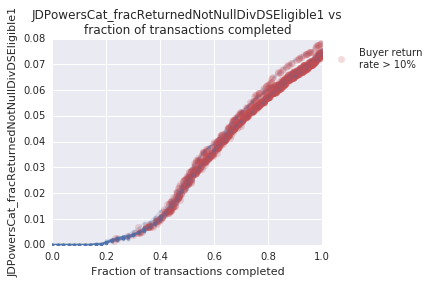

########################################
Category column:    JDPowersCat
Transaction column: JDPowersCat_numTransactions
Fraction column:    JDPowersCat_fracReturned1DivReturnedNotNull
Timestamp: 2017-02-28T07:23:22GMT


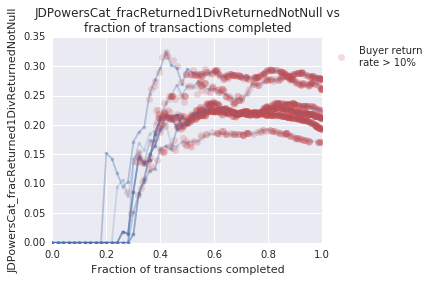

########################################
Category column:    JDPowersCat
Transaction column: JDPowersCat_numTransactions
Fraction column:    JDPowersCat_fracReturnedasm1DivTransactions
Timestamp: 2017-02-28T07:23:44GMT


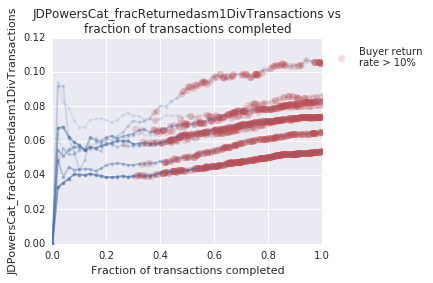

In [12]:
# re-initialize matplotlib inline in case handle dropped
%matplotlib inline
demo.app_predict.predict.plot_eda(
    df=df,
    columns=sorted(df.columns[np.logical_or(df.dtypes=='int64', df.dtypes=='float64')]),
    path_plot_dir=os.path.join(path_data_dir, 'plot_eda'))

Cluster map of feature correlations with heirarchical relationships.
The deeper of the dendrogram node, the higher (anti)correlated the features are.
The Spearman rank correlation accommodates non-linear features.
The pair plot is a scatter matrix plot of columns vs each other.


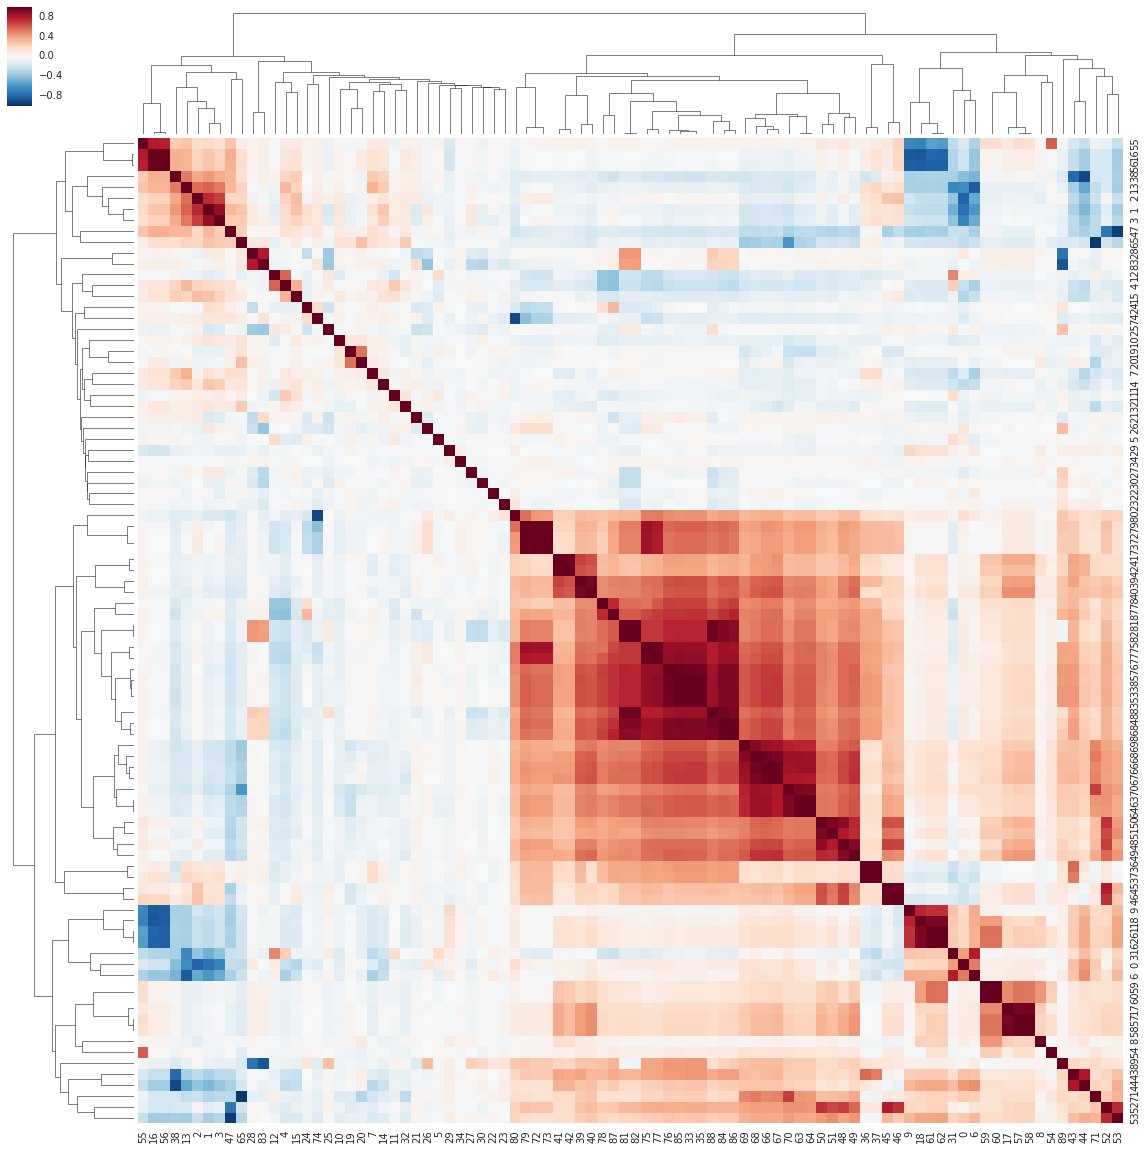

55                                   VIN_numDSEligible1
16                                           DSEligible
56                   VIN_fracDSEligible1DivTransactions
38               BuyerID_fracDSEligible1DivTransactions
13                                          PSIEligible
2                                               CarYear
1                                             SalePrice
3                                                   MMR
47              SellerID_fracDSEligible1DivTransactions
65       SellingLocation_fracDSEligible1DivTransactions
28                                      JDPowersCat_SUV
83           JDPowersCat_fracDSEligible1DivTransactions
12                                               InLane
4                                                LIGHTG
15                                      ConditionReport
24                                JDPowersCat_LUXURYCAR
74               CarMake_fracDSEligible1DivTransactions
25                               JDPowersCat_MID

In [15]:
print(textwrap.dedent("""\
    Cluster map of feature correlations with heirarchical relationships.
    The deeper of the dendrogram node, the higher (anti)correlated the features are.
    The Spearman rank correlation accommodates non-linear features.
    The pair plot is a scatter matrix plot of columns vs each other."""))

# Write column labels to csv file.
path_plot_dir = os.path.join(path_data_dir, 'plot_eda_extra')
cols_plot = df.columns[np.logical_or(df.dtypes=='int64', df.dtypes=='float64')]
ds_columns = pd.Series(cols_plot, name='column')
ds_columns.to_csv(
    os.path.join(path_plot_dir, 'eda-extra_index_column_map.csv'),
    header=True, index_label='index')

# Create clustermap.
df_tmp = df[cols_plot].sample(n=1000, replace=False, random_state=0)
df_tmp.columns = [np.where(ds_columns.values == col)[0][0] for col in df_tmp.columns]
cmap = sns.clustermap(df_tmp.corr(method='spearman'), figsize=(20, 20))
plt.savefig(
    os.path.join(path_plot_dir, 'eda-extra_clustermap.png'),
    bbox_inches='tight', dpi=300)
plt.show()

# Print and write ordered column labels to csv file
with pd.option_context('display.max_rows', len(cmap.data2d.columns)):
    print(ds_columns.loc[cmap.data2d.columns])
ds_columns.loc[cmap.data2d.columns].to_csv(
    os.path.join(path_plot_dir, 'eda-extra_clustermap_index_column_map.csv'),
    header=True, index_label='index')

Cluster map of record correlations with heirarchical relationships.


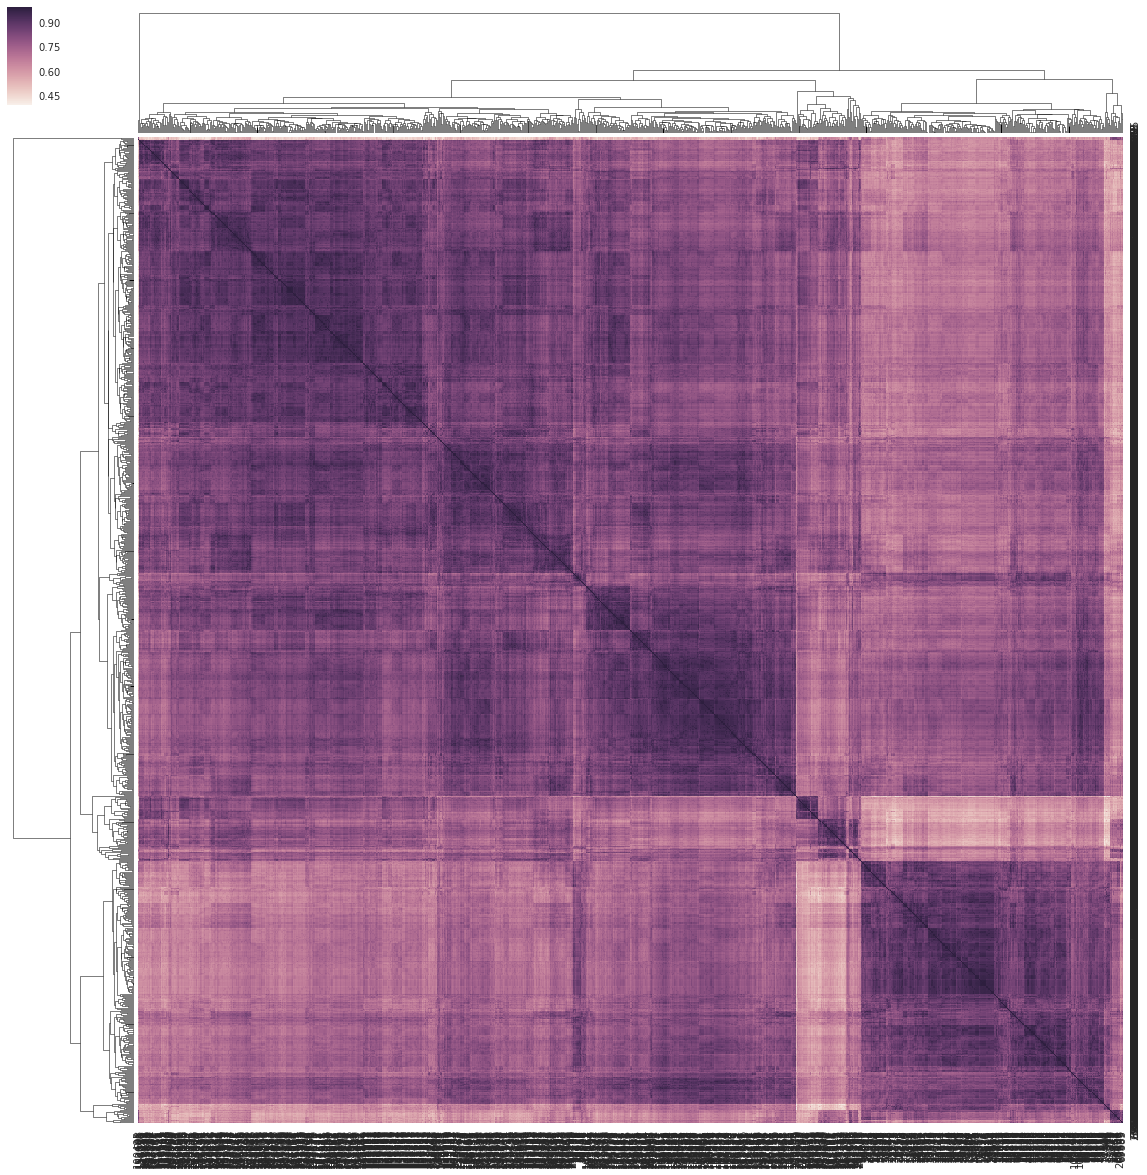

In [16]:
print(textwrap.dedent("""\
    Cluster map of record correlations with heirarchical relationships."""))

# Create clustermap.
sns.clustermap(df_tmp.transpose().corr(method='spearman'), figsize=(20, 20))
plt.savefig(
    os.path.join(path_plot_dir, 'eda-extra_clustermap_records.png'),
    bbox_inches='tight', dpi=300)
plt.show()

Pairplot of columns (ordered like clustermap):


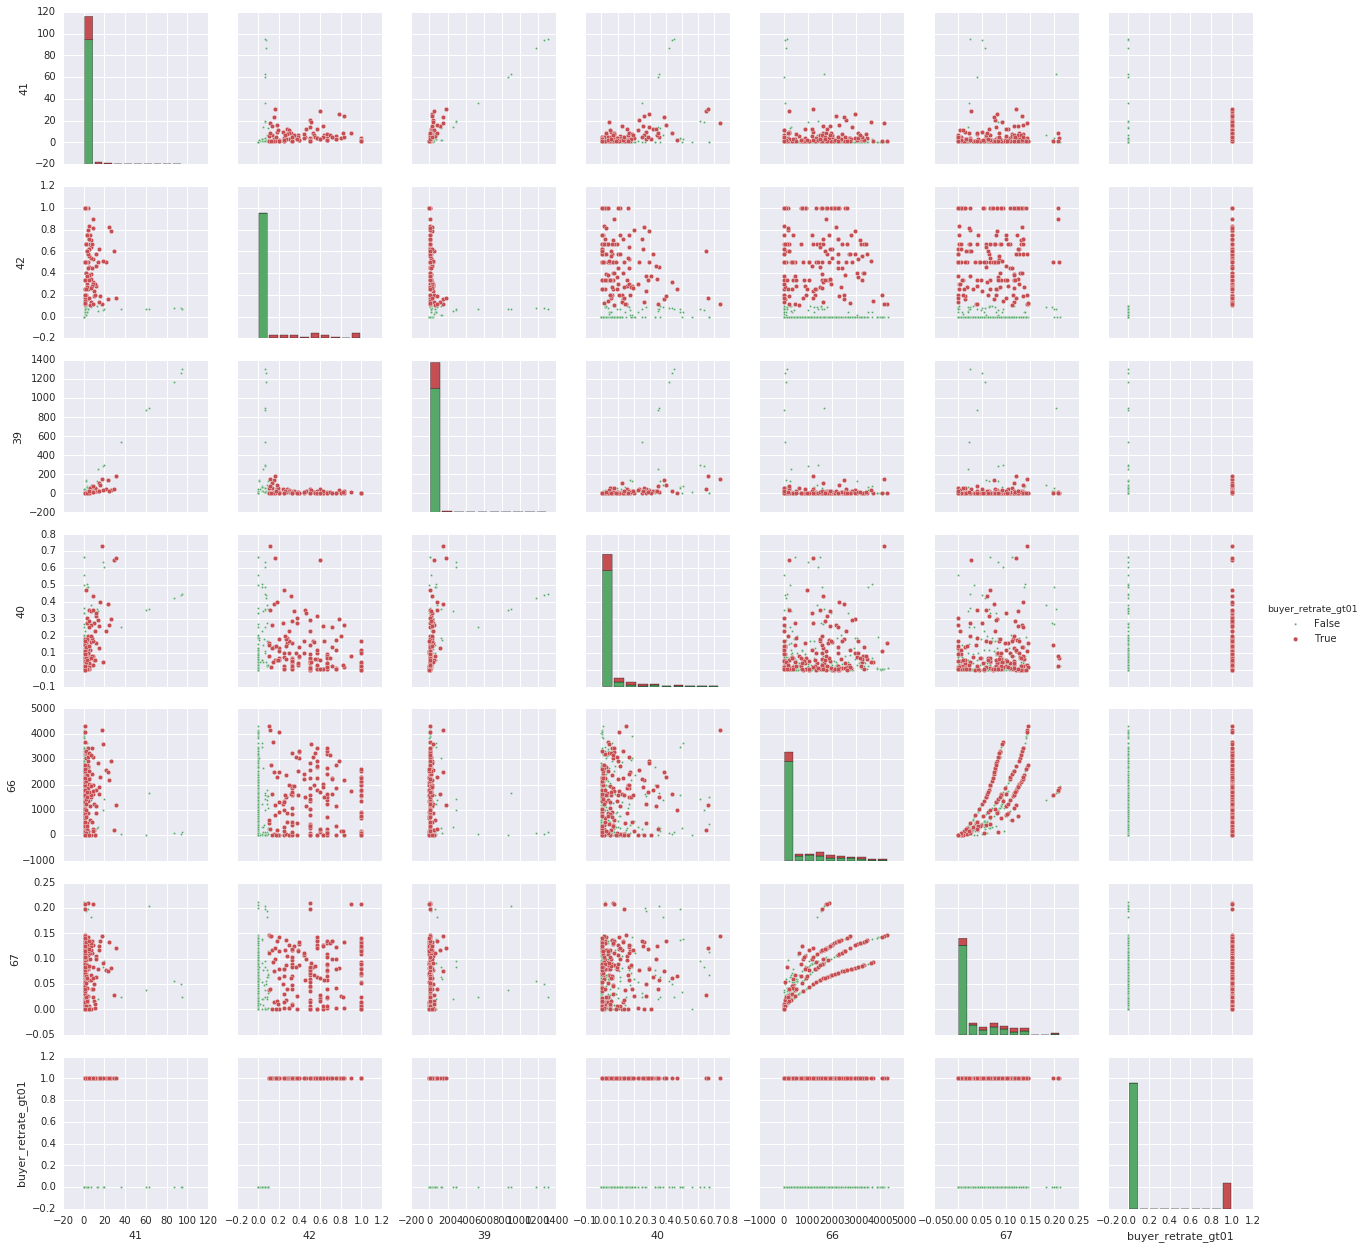

In [17]:
print("Pairplot of columns (ordered like clustermap):")
buyer_retrate_idx = np.where(ds_columns.values == buyer_retrate)[0][0]
idxs_top_corr = cmap.data2d[buyer_retrate_idx].abs().sort_values(ascending=False)[:6].index
tfmask_top_corr = cmap.data2d.index.isin(idxs_top_corr)
col_hue = 'buyer_retrate_gt01'
cols_plot = cmap.data2d.columns[tfmask_top_corr].append(pd.Index([col_hue]))
df_tmp[col_hue] = df_tmp[buyer_retrate_idx] > buyer_retrate_max

sns.pairplot(
    df_tmp[cols_plot], hue=col_hue, diag_kind='hist', markers=['.', 'o'],
    palette=[sns.color_palette()[1], sns.color_palette()[2]],
    plot_kws={'alpha':1.0})
plt.savefig(
    os.path.join(path_plot_dir, 'eda-extra_pairplot.png'),
    bbox_inches='tight', dpi=300)
plt.show()

In [23]:
del df_tmp
gc.collect()

233416

## Heuristic model

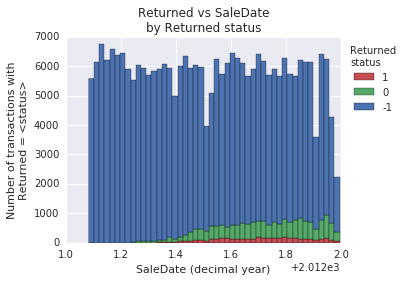

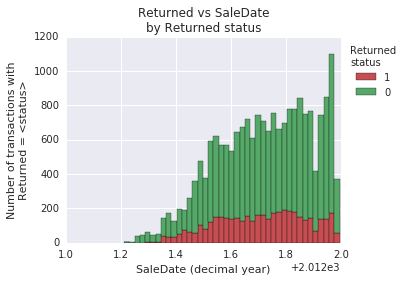

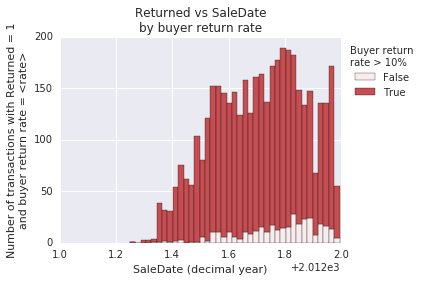

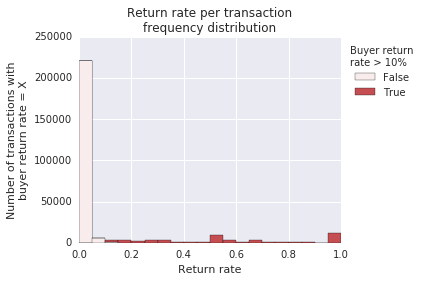

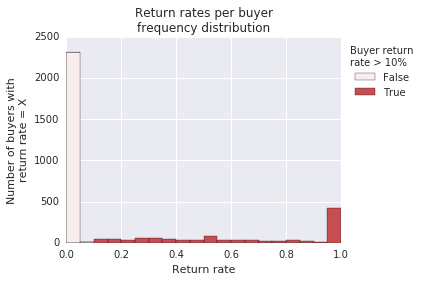

In [13]:
# re-initialize matplotlib inline in case handle dropped
%matplotlib inline
demo.app_predict.predict.plot_heuristic(
    df=df,
    path_plot_dir=os.path.join(path_data_dir, 'plot_heuristic'))

### Test heuristic

Note: The heuristic isn't "trained", just calculated (no iterations).
TODO:
* Bootstrap to get uncertainties.
* **Make list of bad dealers**
* **Predict 'Returned'**: P(Returned < 0.1) then P(Dealer_retrate < 0.1)
* Don't remove Returned == -1 since that means not DealShield approved or yes DealShield approved but not purchased.

In [15]:
date_range = pd.date_range(start=df['SaleDate'].min(), end=df['SaleDate'].max(), freq='W')
df_modl = df.loc[
    np.logical_and(
        date_range[0] <= df['SaleDate'],
        df['SaleDate'] < date_range[1])].copy()
df_orig = df.loc[
    np.logical_and(
        date_range[0] <= df['SaleDate'],
        df['SaleDate'] < date_range[1])].copy()
buyers = np.asarray([])
buyers_prohibited = dict() # key: (df_train['SaleDate'].min(), df_train['SaleDate'].max())
transactions_affected = dict() # key: (df_test['SaleDate'].min(), df_test['SaleDate'].max())
retrates_modl_chunk = dict() # key: (df_test['SaleDate'].min(), df_test['SaleDate'].max())
retrates_orig_chunk = dict() # key: (df_eval['SaleDate'].min(), df_eval['SaleDate'].max())
retrates_modl_all = dict() # key: (df_modl['SaleDate'].min(), df_modl['SaleDate'].max())
retrates_orig_all = dict() # key: (df_orig['SaleDate'].min(), df_orig['SaleDate'].max())

for idx in range(len(date_range)-2):
    print('#'*40)
    print('Timestamp:', time.strftime(r'%Y-%m-%dT%H:%M:%S%Z', time.gmtime()))
    
    # Define data sets.
    (saledate_train_min, saledate_train_max) = (date_range[idx],   date_range[idx+1])
    (saledate_test_min,  saledate_test_max)  = (date_range[idx+1], date_range[idx+2])
    (saledate_eval_min,  saledate_eval_max)  = (date_range[idx+1], date_range[idx+2])
    df_train = df_modl.loc[
        np.logical_and(
            saledate_train_min <= df['SaleDate'],
            df['SaleDate'] < saledate_train_max)].copy()
    df_test = df.loc[
        np.logical_and(
            saledate_test_min <= df['SaleDate'],
            df['SaleDate'] < saledate_test_max)].copy()
    df_eval = df.loc[
        np.logical_and(
            saledate_eval_min <= df['SaleDate'],
            df['SaleDate'] < saledate_eval_max)].copy()
    
    # Prohibit purchase of DealShield in test data:
    # If prohibiting purchase of DealShield,
    # then for prohibed buyers, set DSEligible = 0 and Returned = -1
    buyers = np.unique(
        np.append(
            buyers,
            df_train.loc[df_train[buyer_retrate] > buyer_retrate_max, 'BuyerID'].unique()))
    buyers_prohibited[(df_train['SaleDate'].min(), df_train['SaleDate'].max())] = buyers
    tfmask = np.logical_and(
        np.logical_and(
            df_test['SaleDate'] > df_train['SaleDate'].max(),
            df_test['BuyerID'].isin(buyers)),
        df_test['DSEligible'] == 1)
    transactions_affected[(df_test['SaleDate'].min(), df_test['SaleDate'].max())] = tfmask.loc[tfmask].index
    df_test.loc[tfmask, 'DSEligible'] = 0
    df_test.loc[tfmask, 'Returned'] = -1
    
    # Update calculated features.
    df_modl = demo.app_predict.predict.update_features_append(
        df_prev=df_modl, df_next=df_test, debug=False)
    df_orig = df_orig.append(df_eval)
    
    # Calculate chunk return rates.
    df_chunk = df_modl.loc[
        np.logical_and(
            saledate_test_min <= df_modl['SaleDate'],
            df_modl['SaleDate'] < saledate_test_max)]
    retrate_modl = sum(df_chunk['Returned']==1)/sum(df_chunk['Returned']!=-1)
    df_chunk = df_orig.loc[
        np.logical_and(
            saledate_eval_min <= df_orig['SaleDate'],
            df_orig['SaleDate'] < saledate_eval_max)]
    retrate_orig = sum(df_chunk['Returned']==1)/sum(df_chunk['Returned']!=-1)
    retrates_modl_chunk[(saledate_test_min, saledate_test_max)] = retrate_modl
    retrates_orig_chunk[(saledate_eval_min, saledate_eval_max)] = retrate_orig
    print('Chunk:')
    print('Evaluation time span:', df_chunk['SaleDate'].min(), df_chunk['SaleDate'].max())
    print('Model return rate:   ', retrate_modl)
    print('Original return rate:', retrate_orig)

    # Calculate overall return rates.
    retrate_modl = sum(df_modl['Returned']==1)/sum(df_modl['Returned']!=-1)
    retrate_orig = sum(df_orig['Returned']==1)/sum(df_orig['Returned']!=-1)
    retrates_modl_all[(df_modl['SaleDate'].min(), df_modl['SaleDate'].max())] = retrate_modl
    retrates_orig_all[(df_orig['SaleDate'].min(), df_orig['SaleDate'].max())] = retrate_orig
    print('Overall:')
    print('Evaluation time span:', df_orig['SaleDate'].min(), df_orig['SaleDate'].max())
    print('Model return rate:   ', retrate_modl)
    print('Original return rate:', retrate_orig)

########################################
Timestamp: 2017-02-28T19:27:11GMT
Chunk:
Evaluation time span: 2013-02-10 00:00:00 2013-02-16 00:00:00
Model return rate:    nan
Original return rate: nan
Overall:
Evaluation time span: 2013-02-03 00:00:00 2013-02-16 00:00:00
Model return rate:    nan
Original return rate: nan
########################################
Timestamp: 2017-02-28T19:27:12GMT
Chunk:
Evaluation time span: 2013-02-17 00:00:00 2013-02-23 00:00:00
Model return rate:    nan
Original return rate: nan
Overall:
Evaluation time span: 2013-02-03 00:00:00 2013-02-23 00:00:00
Model return rate:    nan
Original return rate: nan
########################################
Timestamp: 2017-02-28T19:27:12GMT
Chunk:
Evaluation time span: 2013-02-24 00:00:00 2013-03-02 00:00:00
Model return rate:    nan
Original return rate: nan
Overall:
Evaluation time span: 2013-02-03 00:00:00 2013-03-02 00:00:00
Model return rate:    nan
Original return rate: nan
########################################
Ti

Plot performance of heuristic


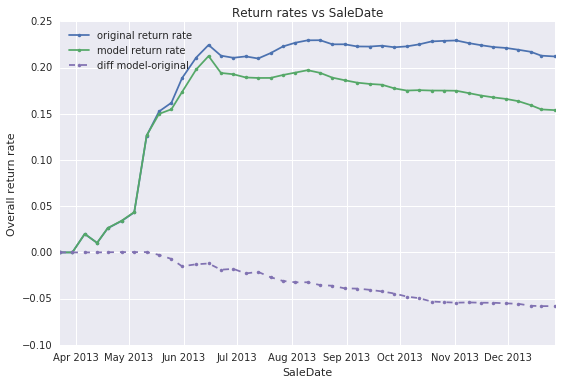

########################################
BuyerID: 272356


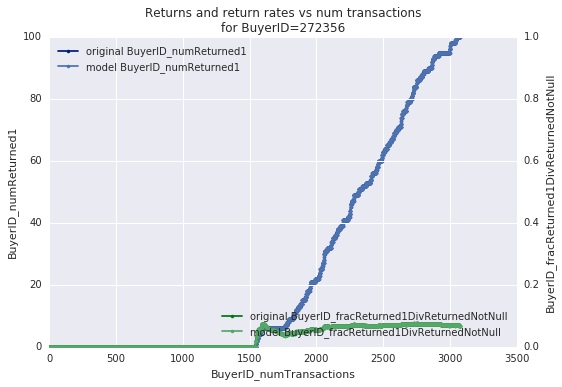

########################################
BuyerID: 328701


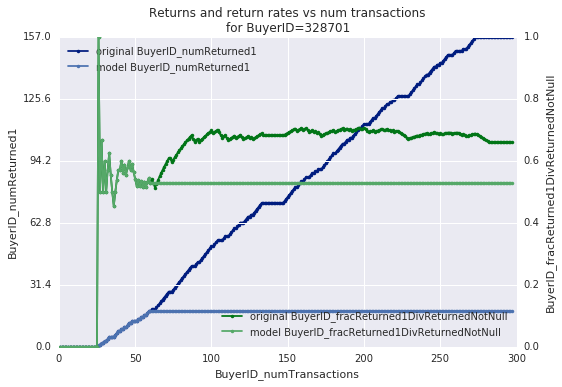

########################################
BuyerID: 179863


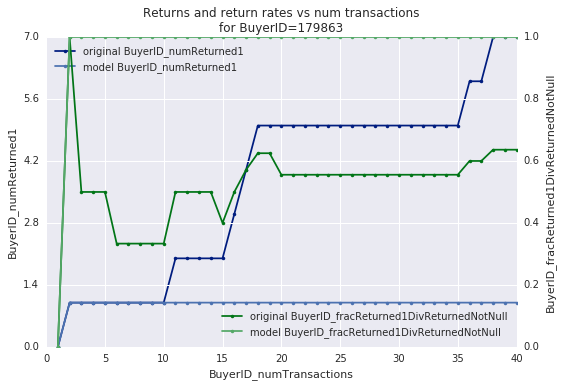

########################################
BuyerID: 46857


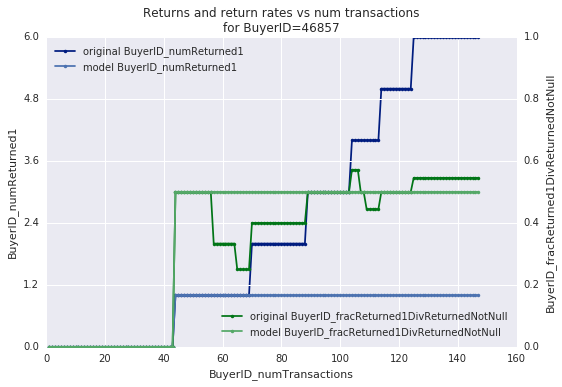

########################################
BuyerID: 62851


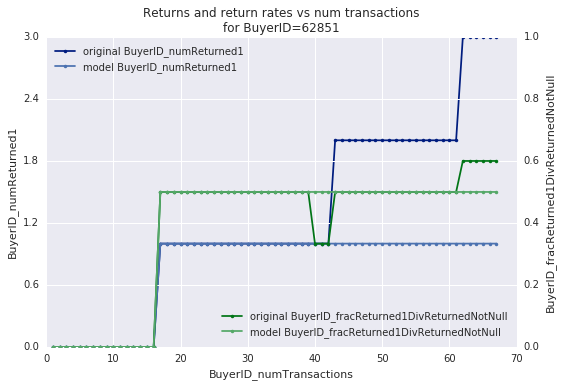

########################################
BuyerID: 16640


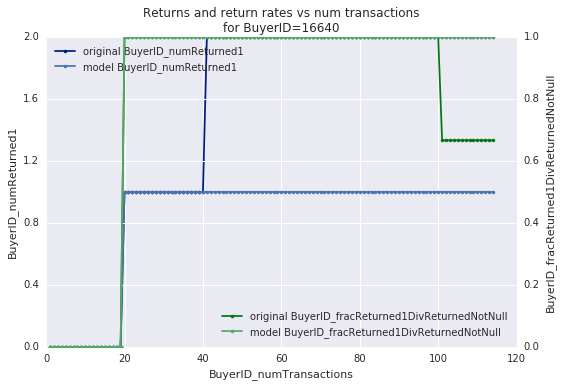

########################################
BuyerID: 61773


/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1, top=1
  'bottom=%s, top=%s') % (bottom, top))


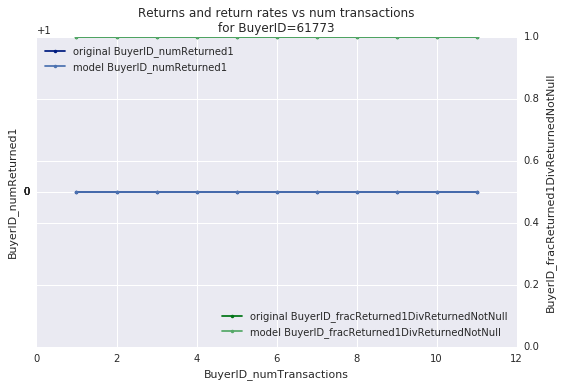

########################################
BuyerID: 20718


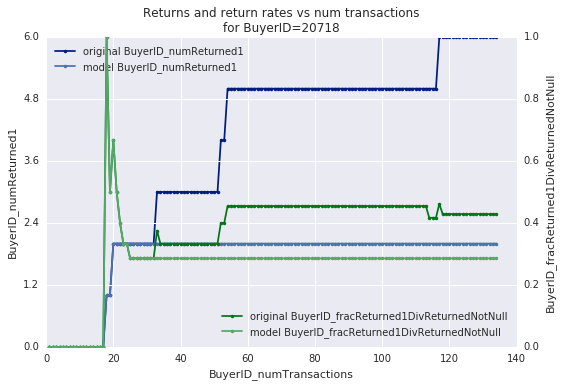

########################################
BuyerID: 18584


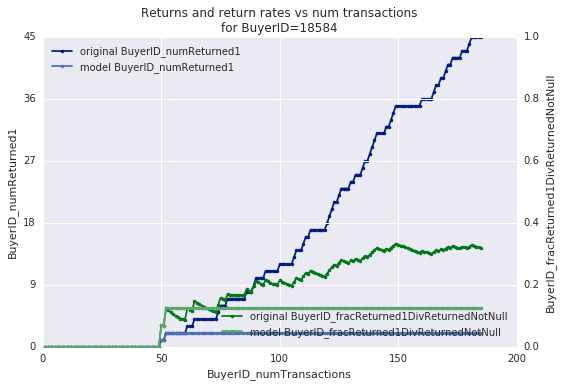

########################################
BuyerID: 248009


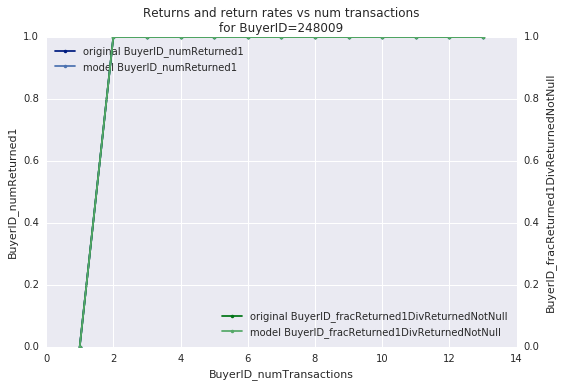

In [21]:
# Overall return rate is Returned==1 / (Returned not null)
print("Plot performance of heuristic")
path_plot_dir = os.path.join(path_data_dir, 'plot_performance_heuristic')

# Plot overall return rate.
(xvals_orig, yvals_orig) = zip(*[(key[1], val) for (key, val) in sorted(retrates_orig_all.items())])
(xvals_modl, yvals_modl) = zip(*[(key[1], val) for (key, val) in sorted(retrates_modl_all.items())])
(xvals_diff, yvals_diff) = (xvals_orig, np.subtract(yvals_modl, yvals_orig))
plt.plot(
    xvals_orig, yvals_orig, marker='.', linestyle='-',
    color=sns.color_palette()[0], label='original return rate')
plt.plot(
    xvals_modl, yvals_modl, marker='.', linestyle='-',
    color=sns.color_palette()[1], label='model return rate')
plt.plot(
    xvals_diff, yvals_diff, marker='.', linestyle='--',
    color=sns.color_palette()[3], label='diff model-original')
plt.title("Return rates vs SaleDate")
plt.xlabel("SaleDate")
plt.ylabel("Overall return rate")
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig(
    os.path.join(path_plot_dir, 'perf-heur_returnrate_vs_saledate.png'),
    dpi=300)
plt.show()

# Plot return rate by buyer.
# Note: to get buyerid with col max: df_orig.loc[df_orig[col].argmax(), 'BuyerID']
buyerids = [
    '272356', # buyer with max BuyerID_numReturnedNotNull (max accepted DealShield)
    '328701', # buyer with max BuyerID_numReturned1 (max returns)
    '179863', # buyer with max BuyerID_fracReturned1DivReturnedNotNull (max return rate) and frequenly prohibited (36 weeks)
    '46857', # buyers frequently prohibited (38 weeks)
    '62851', # buyers frequently prohibited (36 weeks)
    '16640', # buyers frequently prohibited (36 weeks)
    '61773', # buyers frequently prohibited (35 weeks)
    '20718', # buyers frequently prohibited (35 weeks)
    '18584', # buyers frequently prohibited (34 weeks)
    '248009'] # buyers frequently prohibited (34 weeks)

for buyerid in buyerids:
    print('#'*40)
    print('BuyerID:', buyerid)

    fig = plt.figure()
    ax0 = fig.add_subplot(111)
    ax0.set_title(textwrap.dedent("""\
        Returns and return rates vs num transactions
        for BuyerID={buyerid}""".format(buyerid=buyerid)))
    ax0.set_xlabel('BuyerID_numTransactions')

    ax0.set_ylabel('BuyerID_numReturned1')
    lns0 = list()
    xvals_orig = df_orig.loc[df_orig['BuyerID']==buyerid, 'BuyerID_numTransactions'].values
    yvals0_orig = df_orig.loc[df_orig['BuyerID']==buyerid, 'BuyerID_numReturned1'].values
    lns0 += ax0.plot(
        xvals_orig, yvals0_orig, marker='.', linestyle='-', 
        color=sns.color_palette(palette='dark')[0], label='original BuyerID_numReturned1')
    xvals_modl = df_modl.loc[df_modl['BuyerID']==buyerid, 'BuyerID_numTransactions'].values
    yvals0_modl = df_modl.loc[df_modl['BuyerID']==buyerid, 'BuyerID_numReturned1'].values
    lns0 += ax0.plot(
        xvals_modl, yvals0_modl, marker='.', linestyle='-', 
        color=sns.color_palette(palette=None)[0], label='model BuyerID_numReturned1')
    ylim0 = (
        min(min(yvals0_orig), min(yvals0_modl)),
        max(max(max(yvals0_orig), max(yvals0_modl)), 1))
    ax0.set_ylim(ylim0)
    nticks = 6
    ax0.set_yticks(np.linspace(start=ylim0[0], stop=ylim0[1], num=nticks, endpoint=True))
    ax0.legend(lns0, [ln.get_label() for ln in lns0], loc='upper left')

    ax1 = ax0.twinx()
    ax1.set_ylabel(buyer_retrate)
    lns1 = list()
    yvals1_orig = df_orig.loc[df_orig['BuyerID']==buyerid, buyer_retrate].values
    lns1 += ax1.plot(
        xvals_orig, yvals1_orig, marker='.', linestyle='-', 
        color=sns.color_palette(palette='dark')[1], label='original '+buyer_retrate)
    yvals1_modl = df_modl.loc[df_modl['BuyerID']==buyerid, buyer_retrate].values
    lns1 += ax1.plot(
        xvals_modl, yvals1_modl, marker='.', linestyle='-', 
        color=sns.color_palette(palette=None)[1], label='model '+buyer_retrate)
    ylim1 = (0, 1)
    ax1.set_ylim(ylim1)
    ax1.set_yticks(np.linspace(start=ylim1[0], stop=ylim1[1], num=nticks, endpoint=True))
    ax1.legend(lns1, [ln.get_label() for ln in lns1], loc='lower right')
    plt.tight_layout()
    plt.savefig(
        os.path.join(path_plot_dir, 'perf-heur_returnrate_vs_transactions_for_'+buyerid+'.png'),
        dpi=300)
    plt.show(fig)

In [52]:
del df_chunk, df_eval, df_modl, df_orig, df_test, df_train
gc.collect()

## Pipeline model

TODO:
* Try with data subset DSEligible==1, then use LDA instead of PCA to create the features to separate Returned=1/0

In [24]:
# Define target and features
target = 'Returned'
features = set(df.columns[np.logical_or(df.dtypes=='int64', df.dtypes=='float64')])
features.difference_update([target])
features = sorted(features)
features

['Arbitrated',
 'Autocheck_score',
 'BuyerID_fracDSEligible1DivTransactions',
 'BuyerID_fracReturned1DivReturnedNotNull',
 'BuyerID_fracReturnedNotNullDivDSEligible1',
 'BuyerID_fracReturnedasm1DivTransactions',
 'BuyerID_numDSEligible1',
 'BuyerID_numReturned1',
 'BuyerID_numReturnedNotNull',
 'BuyerID_numReturnedasm1',
 'BuyerID_numTransactions',
 'CarMake_fracDSEligible1DivTransactions',
 'CarMake_fracReturned1DivReturnedNotNull',
 'CarMake_fracReturnedNotNullDivDSEligible1',
 'CarMake_fracReturnedasm1DivTransactions',
 'CarMake_numDSEligible1',
 'CarMake_numReturned1',
 'CarMake_numReturnedNotNull',
 'CarMake_numReturnedasm1',
 'CarMake_numTransactions',
 'CarYear',
 'ConditionReport',
 'DSEligible',
 'InLane',
 'JDPowersCat_COMPACTCAR',
 'JDPowersCat_EXCLUDED',
 'JDPowersCat_FULLSIZECAR',
 'JDPowersCat_LUXURYCAR',
 'JDPowersCat_MIDSIZECAR',
 'JDPowersCat_PICKUP',
 'JDPowersCat_SPORTSCAR',
 'JDPowersCat_SUV',
 'JDPowersCat_UNKNOWN',
 'JDPowersCat_VAN',
 'JDPowersCat_fracDSEligible1

In [27]:
print(textwrap.dedent("""\
    `Container`: Create an empty container class and
    dynamically allocate attributes to hold variables for specific steps
    of the pipeline. """))
Container = demo.utils.utils.Container
step = Container()

print(textwrap.dedent("""\
    `step.s0.[df,ds]_[features,target]`: Save initial state of features, target."""))
step.s0 = Container()
step.s0.dfs = Container()
step.s0.dfs.df_features = df[features].copy()
step.s0.dfs.ds_target = df[target].copy()

# TODO: REDO after this point with step.sN.dfs.[df_features,ds_target]
# rather than redefining [df_features,ds_target]
df_features = step.s0.dfs.df_features
ds_target = step.s0.dfs.ds_target

`transformer_scaler`, `transformer_pca`: Scale data
then make groups of similar records with k-means clustering,
both with and without PCA. Use the silhouette score to determine
the number of clusters.

`columns.pkl`, `transformer_scaler.pkl`, `transformer_pca.pkl`: Save column order and transformers.
Plot scores for scaled features:
Progress: 11% 22% 33% 44% 56% 67% 78% 89% 100% 



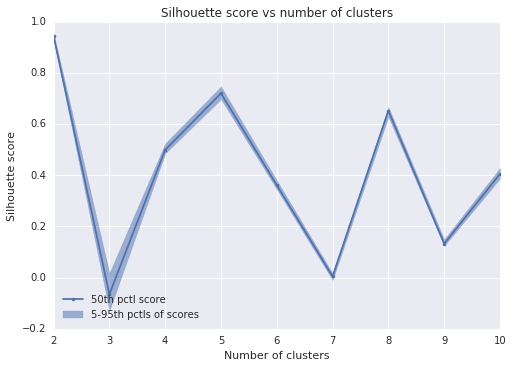

Plot scores for scaled PCA features:
Progress: 11% 22% 33% 44% 56% 67% 78% 89% 100% 



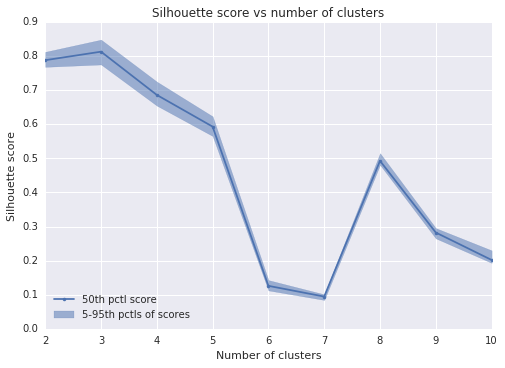

Time elapsed (sec) = 51.2


In [36]:
print(textwrap.dedent("""\
    `transformer_scaler`, `transformer_pca`: Scale data
    then make groups of similar records with k-means clustering,
    both with and without PCA. Use the silhouette score to determine
    the number of clusters.
    """))
time_start = time.perf_counter()

# Scale data prior to comparing clusters with/without PCA. 
# Note: Using sklearn.preprocessing.RobustScaler with
#     sklearn.decomposition.IncrementalPCA(whiten=False)
#     is often the most stable (slowly varying scores)
#     with highest scores. Centroid agreement can still be
#     off due to outliers.
transformer_scaler = sk_pre.RobustScaler()
features_scaled = transformer_scaler.fit_transform(X=df_features)
transformer_pca = sk_dc.IncrementalPCA(whiten=False)
features_scaled_pca = transformer_pca.fit_transform(X=features_scaled)

print("`columns.pkl`, `transformer_scaler.pkl`, `transformer_pca.pkl`: Save column order and transformers.")
path_data = path_data_dir
path_cols = os.path.join(path_data, 'columns.pkl')
with open(path_cols, mode='wb') as fobj:
    pickle.dump(obj=df_features.columns, file=fobj)
path_tform_scl = os.path.join(path_data, 'transformer_scaler.pkl')
with open(path_tform_scl, mode='wb') as fobj:
    pickle.dump(obj=transformer_scaler, file=fobj)
path_tform_pca = os.path.join(path_data, 'transformer_pca.pkl')
with open(path_tform_pca, mode='wb') as fobj:
    pickle.dump(obj=transformer_pca, file=fobj)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    print("Plot scores for scaled features:")
    demo.utils.utils.calc_silhouette_scores(
        df_features=features_scaled, n_clusters_min=2, n_clusters_max=10,
        size_sub=None, n_scores=10, show_progress=True, show_plot=True)

    print("Plot scores for scaled PCA features:")
    demo.utils.utils.calc_silhouette_scores(
        df_features=features_scaled_pca, n_clusters_min=2, n_clusters_max=10,
        size_sub=None, n_scores=10, show_progress=True, show_plot=True)

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

`transformer_kmeans`, `transformer_kmeans_pca`:
Fit k-means to the data with/without PCA and
compare the centroids for the clusters.
`transformer_kmeans.pkl`, `transformer_kmeans_pca.pkl`: Save transformers.


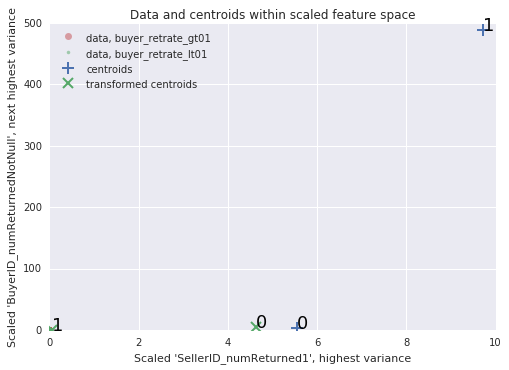

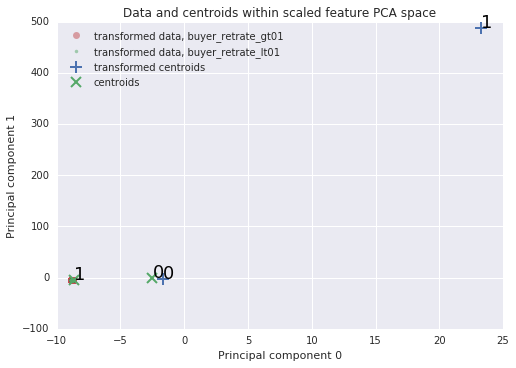

Time elapsed (sec) = 3.3


In [78]:
print(textwrap.dedent("""\
    `transformer_kmeans`, `transformer_kmeans_pca`:
    Fit k-means to the data with/without PCA and
    compare the centroids for the clusters."""))

# TODO: Fix plot. Assign clusters IDs in a deterministic way so that
#   cluster 0 raw matches cluster 0 transformed.
time_start = time.perf_counter()

n_clusters = 2 # from silhouette scores

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Cluster scaled features with/without PCA using minibatch k-means
    transformer_kmeans = sk_cl.MiniBatchKMeans(n_clusters=n_clusters)
    transformer_kmeans.fit(X=features_scaled)
    transformer_kmeans_pca = sk_cl.MiniBatchKMeans(n_clusters=n_clusters)
    transformer_kmeans_pca.fit(X=features_scaled_pca)

print("`transformer_kmeans.pkl`, `transformer_kmeans_pca.pkl`: Save transformers.")
path_tform_km = os.path.join(path_data, 'transformer_kmeans.pkl')
with open(path_tform_km, mode='wb') as fobj:
    pickle.dump(obj=transformer_kmeans, file=fobj)
path_tform_km_pca = os.path.join(path_data, 'transformer_kmeans_pca.pkl')
with open(path_tform_km_pca, mode='wb') as fobj:
    pickle.dump(obj=transformer_kmeans_pca, file=fobj)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Plot clusters in scaled feature space.
    centroids = transformer_kmeans.cluster_centers_
    transformed_centroids = transformer_pca.inverse_transform(transformer_kmeans_pca.cluster_centers_)
    (col_1, col_0) = np.argsort(np.var(features_scaled, axis=0))[-2:]
    (name_1, name_0) = (df_features.columns.values[col_1], df_features.columns.values[col_0])
    plt.title("Data and centroids within scaled feature space")
    tfmask_gt01 = df_features[buyer_retrate] > buyer_retrate_max
    plt.plot(features_scaled[tfmask_gt01, col_0], features_scaled[tfmask_gt01, col_1],
             marker='o', linestyle='', color=sns.color_palette()[2], alpha=0.5,
             label='data, buyer_retrate_gt01')
    tfmask_lt01 = np.logical_not(tfmask_gt01)
    plt.plot(features_scaled[tfmask_lt01, col_0], features_scaled[tfmask_lt01, col_1],
             marker='.', linestyle='', color=sns.color_palette()[1], alpha=0.5,
             label='data, buyer_retrate_lt01')
    plt.plot(centroids[:, col_0], centroids[:, col_1],
             marker='+', linestyle='', markeredgewidth=2, markersize=12,
             color=sns.color_palette()[0], label='centroids')
    for (idx, centroid) in enumerate(centroids):
        plt.annotate(
            str(idx), xy=(centroid[col_0], centroid[col_1]),
            xycoords='data', xytext=(0, 0), textcoords='offset points', color='black',
            fontsize=18, rotation=0)
    plt.plot(transformed_centroids[:, col_0], transformed_centroids[:, col_1],
             marker='x', linestyle='', markeredgewidth=2, markersize=10,
             color=sns.color_palette()[1], label='transformed centroids')
    for (idx, transformed_centroid) in enumerate(transformed_centroids):
        plt.annotate(
            str(idx), xy=(transformed_centroid[col_0], transformed_centroid[col_1]),
            xycoords='data', xytext=(0, 0), textcoords='offset points', color='black',
            fontsize=18, rotation=0)
    plt.xlabel("Scaled '{name}', highest variance".format(name=name_0))
    plt.ylabel("Scaled '{name}', next highest variance".format(name=name_1))
    plt.legend(loc='upper left')
    plt.show()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Plot clusters in scaled feature PCA space.
    transformed_centroids = transformer_pca.transform(transformer_kmeans.cluster_centers_)
    centroids = transformer_kmeans_pca.cluster_centers_
    plt.title("Data and centroids within scaled feature PCA space")
    plt.plot(features_scaled_pca[tfmask_gt01, 0], features_scaled_pca[tfmask_gt01, 1],
             marker='o', linestyle='', color=sns.color_palette()[2], alpha=0.5,
             label='transformed data, buyer_retrate_gt01')
    plt.plot(features_scaled_pca[tfmask_lt01, 0], features_scaled_pca[tfmask_lt01, 1],
             marker='.', linestyle='', color=sns.color_palette()[1], alpha=0.5,
             label='transformed data, buyer_retrate_lt01')
    plt.plot(transformed_centroids[:, 0], transformed_centroids[:, 1],
             marker='+', linestyle='', markeredgewidth=2, markersize=12,
             color=sns.color_palette()[0], label='transformed centroids')
    for (idx, transformed_centroid) in enumerate(transformed_centroids):
        plt.annotate(
            str(idx), xy=(transformed_centroid[0], transformed_centroid[1]),
            xycoords='data', xytext=(0, 0), textcoords='offset points', color='black',
            fontsize=18, rotation=0)
    plt.plot(centroids[:, 0], centroids[:, 1],
             marker='x', linestyle='', markeredgewidth=2, markersize=10,
             color=sns.color_palette()[1], label='centroids')
    for (idx, centroid) in enumerate(centroids):
        plt.annotate(
            str(idx), xy=(centroid[0], centroid[1]),
            xycoords='data', xytext=(0, 0), textcoords='offset points', color='black',
            fontsize=18, rotation=0)
    plt.xlabel('Principal component 0')
    plt.ylabel('Principal component 1')
    plt.legend(loc='upper left')
    plt.show()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

In [84]:
print(textwrap.dedent("""\
    `df_features2`: Combine `df_features` with
    cluster labels, cluster distances, PCA components, PCA cluster labels,
    and PCA cluster distances into `df_features`."""))
time_start = time.perf_counter()

# Cluster labels and distances in feature space.
ds_clusters = pd.Series(
    transformer_kmeans.predict(X=features_scaled),
    index=df_features.index, name='cluster')
n_digits = len(str(len(transformer_kmeans.cluster_centers_)))
columns = [
    'cluster_{num}_dist'.format(num=str(num).rjust(n_digits, '0'))
    for num in range(len(transformer_kmeans.cluster_centers_))]
df_cluster_dists = pd.DataFrame(
    transformer_kmeans.transform(X=features_scaled),
    index=df_features.index, columns=columns)
if not np.all(ds_clusters.values == np.argmin(df_cluster_dists.values, axis=1)):
    raise AssertionError(
        ("Program error. Not all cluster labels match cluster label\n" +
         "with minimum distance to record.\n" +
         "Required: np.all(ds_clusters.values == np.argmin(df_cluster_dists.values, axis=1))"))

# PCA features.
n_digits = len(str(transformer_pca.n_components_))
columns = [
    'pca_comp_{num}'.format(num=str(num).rjust(n_digits, '0'))
    for num in range(transformer_pca.n_components_)]
df_features_pca = pd.DataFrame(
    features_scaled_pca, index=df_features.index, columns=columns)

# Cluster labels and distances in PCA feature space.
ds_clusters_pca = pd.Series(
    transformer_kmeans_pca.predict(X=features_scaled_pca),
    index=df_features.index, name='pca_cluster')
n_digits = len(str(len(transformer_kmeans_pca.cluster_centers_)))
columns = [
    'pca_cluster_{num}_dist'.format(num=str(num).rjust(n_digits, '0'))
    for num in range(len(transformer_kmeans_pca.cluster_centers_))]
df_cluster_dists_pca = pd.DataFrame(
    transformer_kmeans_pca.transform(X=features_scaled_pca),
    index=df_features.index, columns=columns)
if not np.all(ds_clusters_pca.values == np.argmin(df_cluster_dists_pca.values, axis=1)):
    raise AssertionError(
        ("Program error. Not all PCA cluster labels match PCA cluster label\n" +
         "with minimum distance to record.\n" +
         "Required: np.all(ds_clusters_pca.values == np.argmin(df_cluster_dists_pca.values, axis=1))"))

# Combine with original `df_features` into new `df_features2`.
df_features2 = pd.concat(
    [df_features, ds_clusters, df_cluster_dists,
     df_features_pca, ds_clusters_pca, df_cluster_dists_pca],
    axis=1, copy=True)

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

`df_features2`: Combine `df_features` with
cluster labels, cluster distances, PCA components, PCA cluster labels,
and PCA cluster distances into `df_features`.
Time elapsed (sec) = 1.5


`df_importances` , `important_features`, `df_features3`:
`df_features3` is a view into (not a copy) of `df_features2` with only
`important_features`. Feature importance is the normalized reduction
in the loss score. A feature is selected as 'important' if its average
importance is greater than the average importance of the random feature.
Progress: 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 



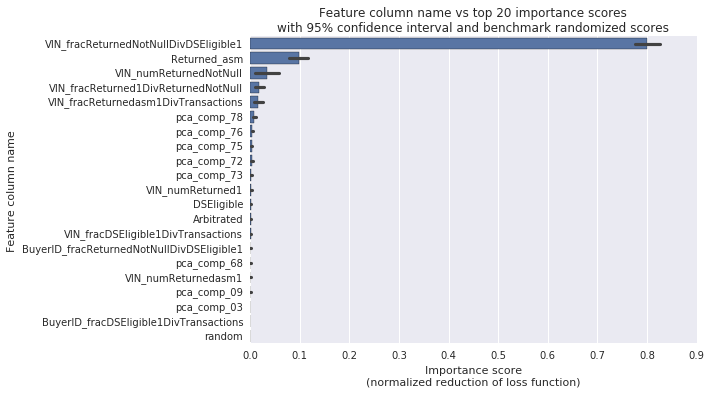

`important_features` =
['VIN_fracReturnedNotNullDivDSEligible1', 'Returned_asm', 'VIN_numReturnedNotNull', 'VIN_fracReturned1DivReturnedNotNull', 'VIN_fracReturnedasm1DivTransactions', 'pca_comp_78', 'pca_comp_76', 'pca_comp_75', 'pca_comp_72', 'pca_comp_73', 'VIN_numReturned1', 'DSEligible', 'Arbitrated', 'VIN_fracDSEligible1DivTransactions', 'BuyerID_fracReturnedNotNullDivDSEligible1', 'pca_comp_68', 'VIN_numReturnedasm1', 'pca_comp_09', 'pca_comp_03', 'BuyerID_fracDSEligible1DivTransactions', 'pca_comp_01', 'pca_comp_57', 'pca_comp_02', 'pca_comp_40', 'VIN_numDSEligible1', 'SellingLocation_lon', 'pca_comp_49', 'pca_comp_41', 'Mileage', 'pca_comp_12', 'BuyerID_fracReturned1DivReturnedNotNull', 'pca_comp_04', 'cluster_1_dist', 'pca_comp_33', 'pca_comp_14', 'SellerID_fracReturnedNotNullDivDSEligible1', 'BuyerID_numReturnedNotNull', 'MMR', 'pca_comp_50', 'pca_comp_48', 'pca_comp_28', 'pca_comp_46', 'pca_comp_34', 'BuyerID_numTransactions', 'pca_comp_61', 'pca_comp_54', 'pca_cluster_1_di

In [85]:
print(textwrap.dedent("""\
    `df_importances` , `important_features`, `df_features3`:
    `df_features3` is a view into (not a copy) of `df_features2` with only
    `important_features`. Feature importance is the normalized reduction
    in the loss score. A feature is selected as 'important' if its average
    importance is greater than the average importance of the random feature."""))
time_start = time.perf_counter()

# Calculate feature importances.
# Note:
# * `n_estimators` impact the feature importances but only have a small
#     effect on the relative importances.
# * `n_estimators` impact the scores but only have a small effect on the relative scores.
# * Use replace=False for maximum data variety.
# TODO: Use a significance test for feature importance.
estimator = sk_ens.ExtraTreesRegressor(n_estimators=10, n_jobs=-1)
df_importances = demo.utils.utils.calc_feature_importances(
    estimator=estimator, df_features=df_features2, ds_target=ds_target,
    replace=False, show_progress=True, show_plot=True)
important_features = df_importances.columns[
    df_importances.mean() > df_importances['random'].mean()]
important_features = list(
    df_importances[important_features].mean().sort_values(ascending=False).index)
df_features3 = df_features2[important_features]
print("`important_features` =")
print(important_features)
print()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

In [86]:
print("`df_features`: Most significant projections of PCA component 78:")
print(sorted(list(zip(df_features, transformer_pca.components_[78])), key=lambda tup: tup[1])[:3])
print('...')
print(sorted(list(zip(df_features, transformer_pca.components_[78])), key=lambda tup: tup[1])[-3:])

`df_features`: Most significant projections of PCA component 78:
[('DSEligible', -0.39888862828646721), ('VIN_numReturned1', -0.16018987870664869), ('Returned_asm', -0.15564636661469736)]
...
[('VIN_numTransactions', 0.094004552775801192), ('VIN_fracReturnedasm1DivTransactions', 0.39932190389544714), ('VIN_fracDSEligible1DivTransactions', 0.76826145356509656)]


Tune feature space by optimizing the model score
with cross validation. Model scores are R^2,
the coefficient of determination.
Progress: 1% 8% 14% 21% 28% 35% 42% 49% 55% 62% 69% 76% 83% 90% 97% 



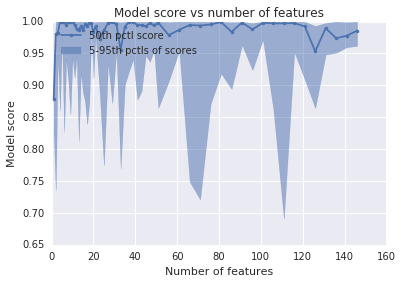

Time elapsed (sec) = 166.8


In [100]:
print(textwrap.dedent("""\
    Tune feature space by optimizing the model score
    with cross validation. Model scores are R^2,
    the coefficient of determination."""))
time_start = time.perf_counter()

print("Progress:", end=' ')
size_data = len(df_features3)
size_sub = 1000
frac_test = 0.2
replace = False
n_scores = 10
estimator = sk_ens.ExtraTreesRegressor(n_estimators=10, n_jobs=-1)
nftrs_scores = list()
idxs = itertools.chain(range(0, 20), range(20, 50, 2), range(50, len(important_features), 5))
for idx in idxs:
    n_ftrs = idx+1
    ftrs = important_features[:n_ftrs]
    scores = list()
    for _ in range(0, n_scores):
        idxs_sub = np.random.choice(a=size_data, size=size_sub, replace=replace)
        (ftrs_train, ftrs_test,
         trg_train, trg_test) = sk_cv.train_test_split(
            df_features3[ftrs].values[idxs_sub], ds_target.values[idxs_sub],
            test_size=frac_test)
        estimator.fit(X=ftrs_train, y=trg_train)
        scores.append(estimator.score(X=ftrs_test, y=trg_test))
    nftrs_scores.append([n_ftrs, scores])
    if idx % 10 == 0:
        print("{frac:.0%}".format(frac=(idx+1)/len(important_features)), end=' ')
print('\n')

nftrs_pctls = np.asarray(
    [np.append(tup[0], np.percentile(tup[1], q=[5,50,95]))
     for tup in nftrs_scores])
plt.plot(
    nftrs_pctls[:, 0], nftrs_pctls[:, 2],
    marker='.', color=sns.color_palette()[0],
    label='50th pctl score')
plt.fill_between(
    nftrs_pctls[:, 0],
    y1=nftrs_pctls[:, 1],
    y2=nftrs_pctls[:, 3],
    alpha=0.5, color=sns.color_palette()[0],
    label='5-95th pctls of scores')
plt.title("Model score vs number of features")
plt.xlabel("Number of features")
plt.ylabel("Model score")
plt.legend(loc='upper left')
plt.show()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

`important_features2`, `df_features4`:
`df_features4` is a view into (not a copy) of `df_features3` with only
`important_features2`. Feature importance is the normalized reduction
in the loss score. A feature is selected as 'important' from the
model score vs features plot.

`important_features2` =
['VIN_fracReturnedNotNullDivDSEligible1', 'Returned_asm', 'VIN_numReturnedNotNull', 'VIN_fracReturned1DivReturnedNotNull', 'VIN_fracReturnedasm1DivTransactions', 'pca_comp_78', 'pca_comp_76', 'pca_comp_75', 'pca_comp_72', 'pca_comp_73']

Cluster map of important feature correlations with heirarchical relationships.
The deeper of the dendrogram node, the higher (anti)correlated the features are.
The Spearman rank correlation accommodates non-linear features.
The pair plot is a scatter matrix plot of columns vs each other.

Clustermap of target, 'Returned', top 10 important features, buyer_retrate_gt01:


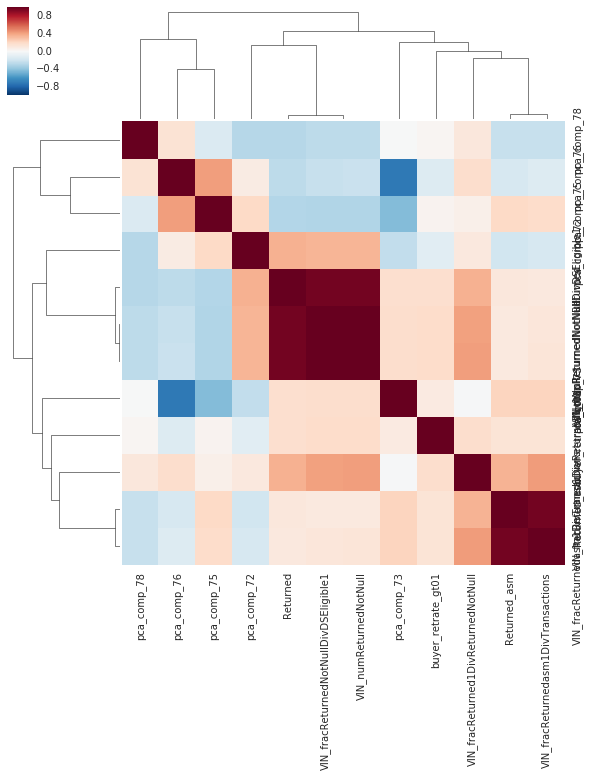

Pairplot of target, 'Returned', top 5 important features, buyer_retrate_gt01:
Index(['Returned', 'VIN_fracReturnedNotNullDivDSEligible1', 'Returned_asm',
       'VIN_numReturnedNotNull', 'VIN_fracReturned1DivReturnedNotNull',
       'VIN_fracReturnedasm1DivTransactions', 'buyer_retrate_gt01'],
      dtype='object')


/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

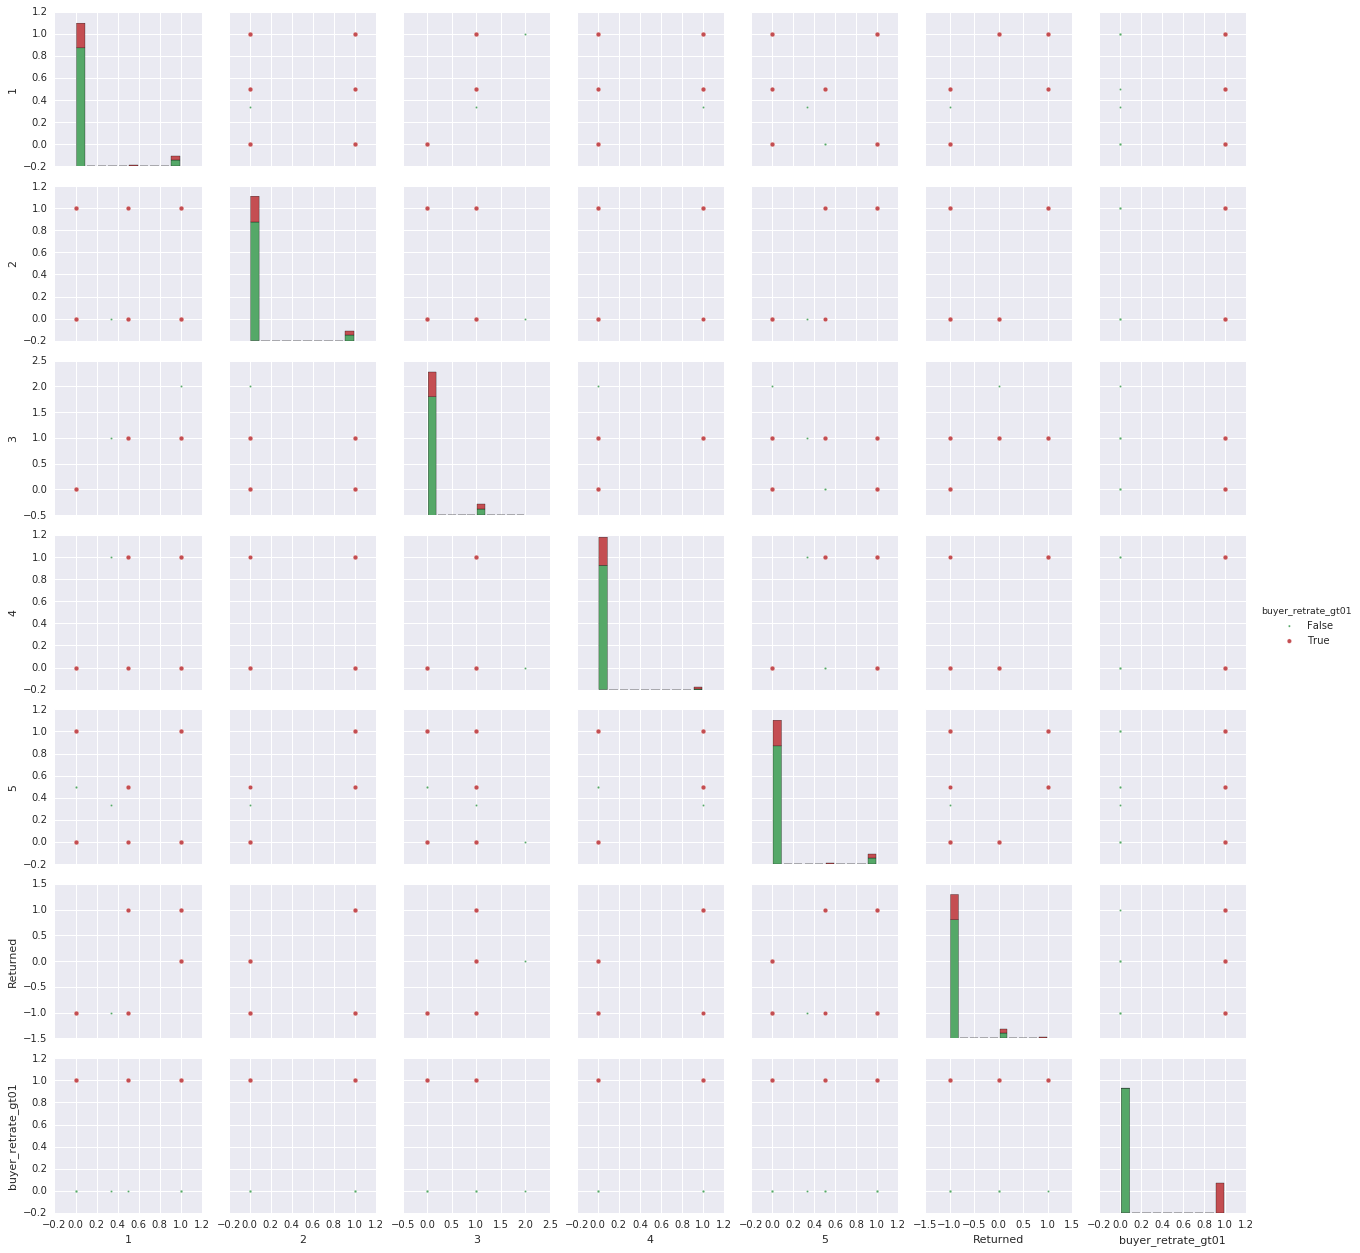

Summarize top 5 important features:
       VIN_fracReturnedNotNullDivDSEligible1   Returned_asm  \
count                          278337.000000  278337.000000   
mean                                0.072437       0.070095   
std                                 0.254448       0.255307   
min                                 0.000000       0.000000   
5%                                  0.000000       0.000000   
15.9%                               0.000000       0.000000   
50%                                 0.000000       0.000000   
84.1%                               0.000000       0.000000   
95%                                 1.000000       1.000000   
max                                 1.000000       1.000000   

       VIN_numReturnedNotNull  VIN_fracReturned1DivReturnedNotNull  \
count           278337.000000                        278337.000000   
mean                 0.079350                             0.020815   
std                  0.277162                             0.

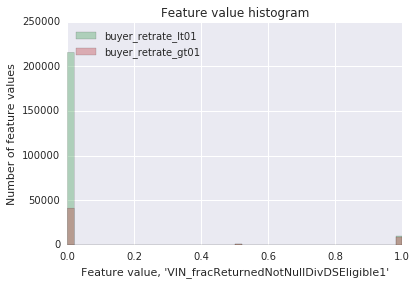

Returned_asm:
    importance: 0.099


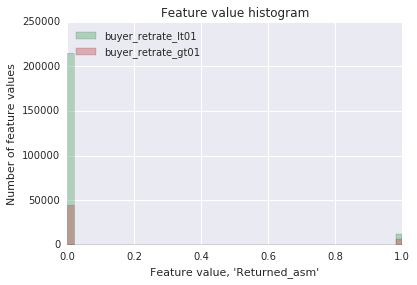

VIN_numReturnedNotNull:
    importance: 0.033


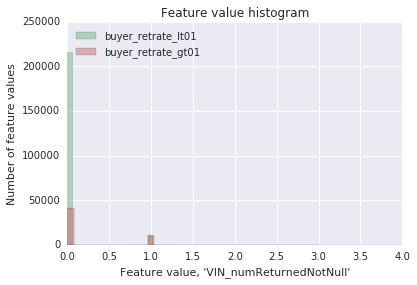

VIN_fracReturned1DivReturnedNotNull:
    importance: 0.018


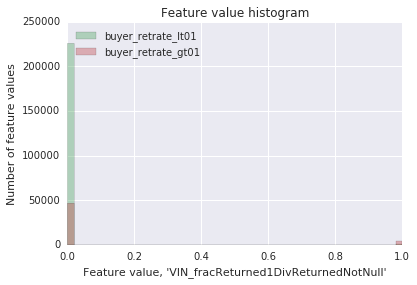

VIN_fracReturnedasm1DivTransactions:
    importance: 0.016


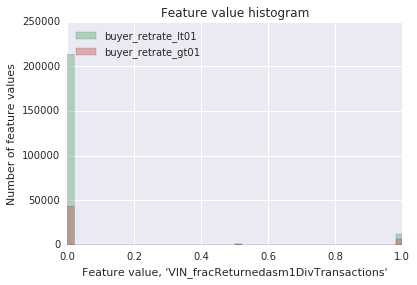

Time elapsed (sec) = 23.9


In [120]:
print("""`important_features2`, `df_features4`:
`df_features4` is a view into (not a copy) of `df_features3` with only
`important_features2`. Feature importance is the normalized reduction
in the loss score. A feature is selected as 'important' from the
model score vs features plot.
""")
time_start = time.perf_counter()

# Keep top 10 features from score vs features plot.
important_features2 = important_features[:10]

df_features4 = df_features3[important_features2]
print("`important_features2` =")
print(important_features2)
print()

print("""Cluster map of important feature correlations with heirarchical relationships.
The deeper of the dendrogram node, the higher (anti)correlated the features are.
The Spearman rank correlation accommodates non-linear features.
The pair plot is a scatter matrix plot of columns vs each other.
""")
path_plot_dir = os.path.join(path_data_dir, 'plot_model')

# Notes:
# * `size_sub` for computing correlations should be <= 1e3 else runtime is long.
# * Use replace=False to show most data variety.
# * For pairplot, only plot the target variable with the top 5 important
#     features for legibility.
# * For clustermap, `nlabels` shows every `nlabels`th label, so 20 labels total.
size_sub = min(int(1e3), len(df_features4.index))
idxs_sub = np.random.choice(a=df_features4.index, size=size_sub, replace=False)
df_plot_sub = df_features4.loc[idxs_sub].copy()
df_plot_sub[target] = ds_target.loc[idxs_sub].copy()
df_plot_sub['buyer_retrate_gt01'] = df_features3.loc[idxs_sub, buyer_retrate] > buyer_retrate_max

print(("Clustermap of target, '{target}', top 10 important features, buyer_retrate_gt01:").format(
        target=target))
sns.clustermap(df_plot_sub[[target]+important_features2[:10]+['buyer_retrate_gt01']].corr(method='spearman'))
plt.savefig(
    os.path.join(path_plot_dir, 'model_clustermap.png'),
    bbox_inches='tight', dpi=300)
plt.show()

print(("Pairplot of target, '{target}', top 5 important features, buyer_retrate_gt01:").format(
        target=target))
df_pairplot = df_plot_sub[[target]+important_features2[:5]+['buyer_retrate_gt01']]
print(df_pairplot.columns)
ds_columns = pd.Series(df_pairplot.columns, name='column')
ds_columns.to_csv(
    os.path.join(path_plot_dir, 'model_pairplot_index_column_map.csv'),
    header=True, index_label='index')
df_pairplot.columns = ds_columns.index
df_pairplot.loc[:, target] = df_pairplot[np.where(ds_columns.values == target)[0][0]]
df_pairplot.loc[:, 'buyer_retrate_gt01'] = df_pairplot[np.where(ds_columns.values == 'buyer_retrate_gt01')[0][0]]
df_pairplot.drop([np.where(ds_columns.values == target)[0][0]], axis=1, inplace=True)
df_pairplot.drop([np.where(ds_columns.values == 'buyer_retrate_gt01')[0][0]], axis=1, inplace=True)
sns.pairplot(
    df_pairplot,
    hue='buyer_retrate_gt01', diag_kind='hist', markers=['.', 'o'],
    palette=[sns.color_palette()[1], sns.color_palette()[2]],
    plot_kws={'alpha':1.0})
plt.savefig(
    os.path.join(path_plot_dir, 'model_pairplot.png'),
    bbox_inches='tight', dpi=300)
plt.show()

print("Summarize top 5 important features:")
print(df_features4[important_features2[:5]].describe(percentiles=percentiles, include='all'))
print()
print("First 5 records for top 5 important features:")
print(df_features4[important_features2[:5]].head())
print()
print("""Describe top 5 important features. Format:
Feature: importance score.
Histogram of feature values.""")
cols_scores = df_importances[important_features2[:5]].mean().items()
for (col, score) in cols_scores:
    # Describe feature variables.
    print(
        ("{col}:\n" +
         "    importance: {score:.3f}").format(col=col, score=score))
    # Plot histogram of feature variables.
    tfmask_gt01 = df_features3[buyer_retrate] > buyer_retrate_max
    sns.distplot(
        df_features4.loc[np.logical_not(tfmask_gt01), col], hist=True, kde=False, norm_hist=False,
        label='buyer_retrate_lt01', color=sns.color_palette()[1])
    sns.distplot(
        df_features4.loc[tfmask_gt01, col], hist=True, kde=False, norm_hist=False,
        label='buyer_retrate_gt01', color=sns.color_palette()[2])
    plt.title('Feature value histogram')
    plt.xlabel("Feature value, '{ftr}'".format(ftr=col))
    plt.ylabel('Number of feature values')
    plt.legend(loc='upper left')
    plt.show()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

Tune model hyperparameters by optimizing the model score
with cross validation. Model scores are R^2,
the coefficient of determination.

Progress: 25% 50% 75% 100% 



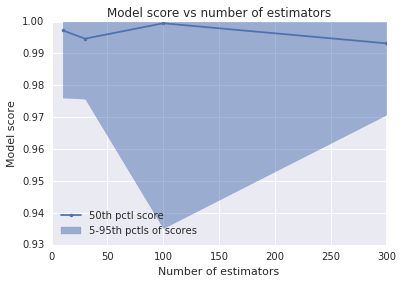

Time elapsed (sec) = 11.5


In [121]:
print("""Tune model hyperparameters by optimizing the model score
with cross validation. Model scores are R^2,
the coefficient of determination.
""")
time_start = time.perf_counter()

print("Progress:", end=' ')
size_data = len(df_features4)
size_sub = min(len(df_features4), int(2e3))
frac_test = 0.2
replace = False
nest_list = [10, 30, 100, 300]
n_scores = 10
nest_scores = list()
for (inum, n_est) in enumerate(nest_list):
    estimator = sk_ens.ExtraTreesRegressor(n_estimators=n_est, n_jobs=-1)
    scores = list()
    for _ in range(0, n_scores):
        idxs_sub = np.random.choice(a=size_data, size=size_sub, replace=replace)
        (ftrs_train, ftrs_test,
         trg_train, trg_test) = sk_cv.train_test_split(
            df_features4.values[idxs_sub], ds_target.values[idxs_sub],
            test_size=frac_test)
        estimator.fit(X=ftrs_train, y=trg_train)
        scores.append(estimator.score(
                X=ftrs_test, y=trg_test))
    nest_scores.append([n_est, scores])
    print("{frac:.0%}".format(frac=(inum+1)/len(nest_list)), end=' ')
print('\n')

nest_pctls = np.asarray(
    [np.append(tup[0], np.percentile(tup[1], q=[5,50,95]))
     for tup in nest_scores])
plt.plot(
    nest_pctls[:, 0], nest_pctls[:, 2],
    marker='.', color=sns.color_palette()[0],
    label='50th pctl score')
plt.fill_between(
    nest_pctls[:, 0],
    y1=nest_pctls[:, 1],
    y2=nest_pctls[:, 3],
    alpha=0.5, color=sns.color_palette()[0],
    label='5-95th pctls of scores')
plt.title("Model score vs number of estimators")
plt.xlabel("Number of estimators")
plt.ylabel("Model score")
plt.legend(loc='lower left')
plt.show()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

Test significance of predictions by shuffling the target values.
Model scores are r^2, the coefficient of determination.

Progress: 5% 25% 45% 65% 85% 



/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


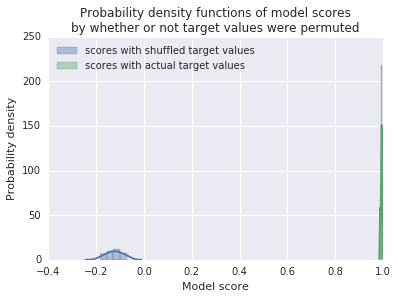

Average model score with shuffling: -0.123
Average model score without shuffling: 0.992


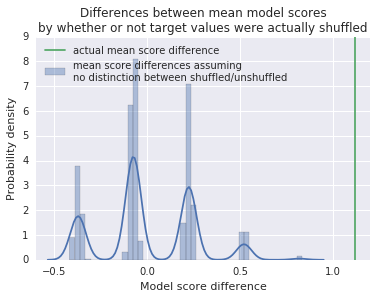

Null hypothesis: There is no distinction in the differences
between the mean model scores whether or not the target
values have been shuffled.
Outcome: Assuming the null hypothesis, the probability of
obtaining a difference between the mean model scores at least
as great as 1.12 is 0.0%.

Time elapsed (sec) = 11.9


In [124]:
print("""Test significance of predictions by shuffling the target values.
Model scores are r^2, the coefficient of determination.
""")
n_estimators = 50 # from tuning curve
time_start = time.perf_counter()

# Calculate significance of score.
estimator = sk_ens.ExtraTreesRegressor(n_estimators=n_estimators, n_jobs=-1)
demo.utils.utils.calc_score_pvalue(
    estimator=estimator, df_features=df_features4, ds_target=ds_target,
    n_iter=20, size_sub=None, frac_test=0.2,
    replace=False, show_progress=True, show_plot=True)
print()

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

Predict target values with cross-validation,
plot actual vs predicted and score.

Progress: 20% 40% 60% 80% 100% 

Model score = 0.995


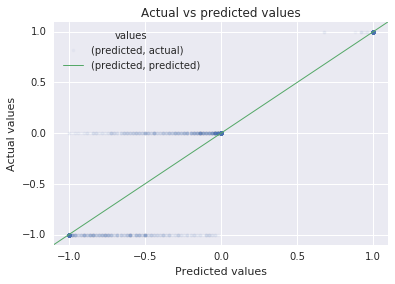

`features.pkl`, `estimator.pkl`: Save features and estimator.

Time elapsed (sec) = 6.4


In [131]:
print("""Predict target values with cross-validation,
plot actual vs predicted and score.
""")
n_estimators = 50 # from tuning curve
time_start = time.perf_counter()

print("Progress:", end=' ')
n_folds = 5
estimator = sk_ens.ExtraTreesRegressor(n_estimators=n_estimators, n_jobs=-1)
kfolds = sk_cv.KFold(n=len(df_features4), n_folds=n_folds, shuffle=True)
ds_predicted = pd.Series(index=ds_target.index, name=target+'_pred')
idxs_pred = set()
for (inum, (idxs_train, idxs_test)) in enumerate(kfolds):
    if not idxs_pred.isdisjoint(idxs_test):
        raise AssertionError(
            ("Program error. Each record must be predicted only once.\n" +
             "Required: idxs_pred.isdisjoint(idxs_test)"))
    idxs_pred.update(idxs_test)
    ftrs_train = df_features4.values[idxs_train]
    ftrs_test  = df_features4.values[idxs_test]
    trg_train  = ds_target.values[idxs_train]
    trg_test   = ds_target.values[idxs_test]
    estimator.fit(X=ftrs_train, y=trg_train)
    ds_predicted.iloc[idxs_test] = estimator.predict(X=ftrs_test)
    print("{frac:.0%}".format(frac=(inum+1)/n_folds), end=' ')
print('\n')

score = sk_met.r2_score(
    y_true=ds_target, y_pred=ds_predicted)
print("Model score = {score:.3f}".format(score=score))
path_plot_dir = os.path.join(path_data_dir, 'plot_model')
demo.utils.utils.plot_actual_vs_predicted(
    y_true=ds_target.values, y_pred=ds_predicted.values,
    loglog=False, xylims=(-1.1, 1.1),
    path=os.path.join(path_plot_dir, 'model_actual_vs_predicted.jpg'))

print("""`features.pkl`, `estimator.pkl`: Save features and estimator.
""")
path_ftr = os.path.join(path_data, 'features.pkl')
with open(path_ftr, mode='wb') as fobj:
    pickle.dump(obj=df_features4.columns, file=fobj)
path_est = os.path.join(path_data, 'estimator.pkl')
with open(path_est, mode='wb') as fobj:
    pickle.dump(obj=estimator, file=fobj)

time_stop = time.perf_counter()
print("Time elapsed (sec) = {diff:.1f}".format(diff=time_stop-time_start))

################################################################################
Features:
['Arbitrated', 'Autocheck_score', 'BuyerID_fracDSEligible1DivTransactions', 'BuyerID_fracReturned1DivReturnedNotNull', 'BuyerID_fracReturnedNotNullDivDSEligible1', 'BuyerID_fracReturnedasm1DivTransactions', 'BuyerID_numDSEligible1', 'BuyerID_numReturned1', 'BuyerID_numReturnedNotNull', 'BuyerID_numReturnedasm1', 'BuyerID_numTransactions', 'CarMake_fracDSEligible1DivTransactions', 'CarMake_fracReturned1DivReturnedNotNull', 'CarMake_fracReturnedNotNullDivDSEligible1', 'CarMake_fracReturnedasm1DivTransactions', 'CarMake_numDSEligible1', 'CarMake_numReturned1', 'CarMake_numReturnedNotNull', 'CarMake_numReturnedasm1', 'CarMake_numTransactions', 'CarYear', 'ConditionReport', 'DSEligible', 'InLane', 'JDPowersCat_COMPACTCAR', 'JDPowersCat_EXCLUDED', 'JDPowersCat_FULLSIZECAR', 'JDPowersCat_LUXURYCAR', 'JDPowersCat_MIDSIZECAR', 'JDPowersCat_PICKUP', 'JDPowersCat_SPORTSCAR', 'JDPowersCat_SUV', 'JDPowersCat_

/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/opt/demo/demo/app_predict/predict.py:1836: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Summarize top 5 important features:
       VIN_fracReturnedNotNullDivDSEligible1   Returned_asm  \
count                          278337.000000  278337.000000   
mean                                0.072437       0.070095   
std                                 0.254448       0.255307   
min                                 0.000000       0.000000   
25%                                 0.000000       0.000000   
50%                                 0.000000       0.000000   
75%                                 0.000000       0.000000   
max                                 1.000000       1.000000   

       VIN_numReturnedNotNull  VIN_fracReturned1DivReturnedNotNull  \
count           278337.000000                        278337.000000   
mean                 0.079350                             0.020815   
std                  0.277162                             0.141990   
min                  0.000000                             0.000000   
25%                  0.000000                 

/opt/conda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


Null hypothesis: There is no distinction in the differences
between the mean model scores whether or not the target
values have been shuffled.
Outcome: Assuming the null hypothesis, the probability of
obtaining a difference between the mean model scores at least
as great as 1.11 is 0.0%.

Time elapsed (sec) = 11.5

################################################################################
Predict target values with cross-validation,
    plot actual vs predicted and score.
    
Progress: 20% 40% 60% 80% 100% 

Model score = 0.995
`features.pkl`, `estimator.pkl`: Save features and estimator.
    
Time elapsed (sec) = 6.3



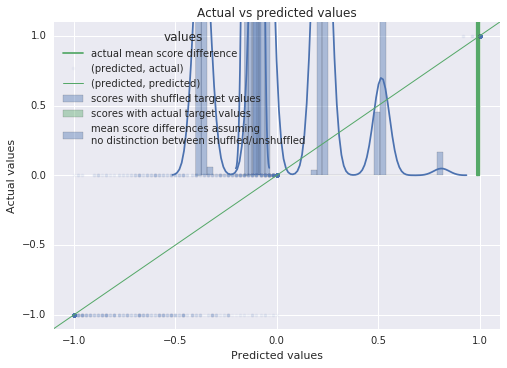

In [142]:
demo.app_predict.predict.create_pipeline_model(df=df, path_data_dir=path_data_dir, show_plots=False)

In [140]:
gc.collect()

26190

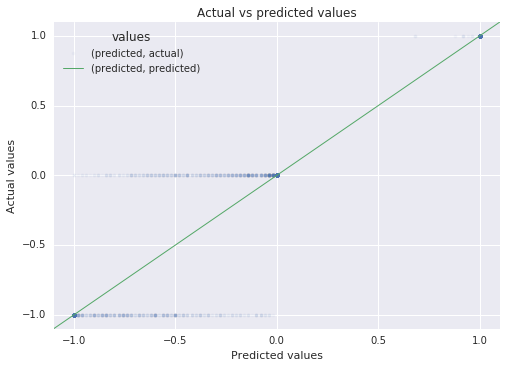

In [143]:
demo.utils.utils.plot_actual_vs_predicted(
    y_true=ds_target.values, y_pred=ds_predicted.values,
    loglog=False, xylims=(-1.1, 1.1),
    path=os.path.join(path_plot_dir, 'model_actual_vs_predicted.jpg'))

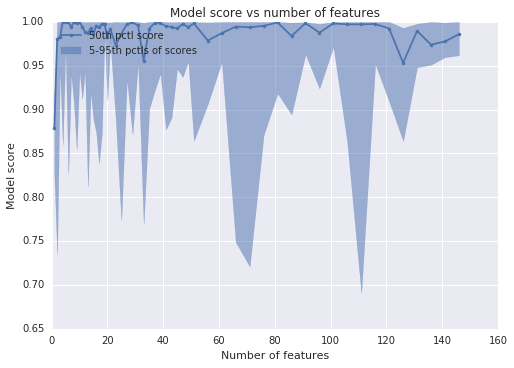

In [145]:
nftrs_pctls = np.asarray(
    [np.append(tup[0], np.percentile(tup[1], q=[5,50,95]))
     for tup in nftrs_scores])
plt.plot(
    nftrs_pctls[:, 0], nftrs_pctls[:, 2],
    marker='.', color=sns.color_palette()[0],
    label='50th pctl score')
plt.fill_between(
    nftrs_pctls[:, 0],
    y1=nftrs_pctls[:, 1],
    y2=nftrs_pctls[:, 3],
    alpha=0.5, color=sns.color_palette()[0],
    label='5-95th pctls of scores')
plt.title("Model score vs number of features")
plt.xlabel("Number of features")
plt.ylabel("Model score")
plt.legend(loc='upper left')
plt.savefig(os.path.join(path_plot_dir, 'model_tune_nfeatures.png'), dpi=300)
plt.show()

### Test pipeline model

In [ ]:
    plt.savefig(
        os.path.join(path_plot_dir, 'model_clustermap.png'),
        bbox_inches='tight', dpi=300)